# Financial Data Preprocessing and Exploratory Data Analysis

## Overview
This notebook performs comprehensive preprocessing and exploratory data analysis on financial time series data for three key assets:
- **TSLA (Tesla Inc.)**: High-growth, high-risk stock in the automobile manufacturing sector
- **BND (Vanguard Total Bond Market ETF)**: Bond ETF providing stability and income
- **SPY (S&P 500 ETF)**: ETF tracking the S&P 500 Index for broad market exposure

The analysis covers data from July 1, 2015, to July 31, 2025, and includes:
- Data cleaning and preprocessing
- Exploratory data analysis with visualizations
- Volatility analysis and risk metrics calculation
- Stationarity testing and outlier detection

In [1]:
# Import Required Libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Define Asset Tickers and Date Range
TICKERS = ['TSLA', 'BND', 'SPY']
START_DATE = '2015-07-01'
END_DATE = '2025-07-31'

print(f"Asset tickers: {TICKERS}")
print(f"Date range: {START_DATE} to {END_DATE}")

# Asset descriptions
asset_info = {
    'TSLA': 'Tesla Inc. - High-growth, high-risk automobile manufacturing stock',
    'BND': 'Vanguard Total Bond Market ETF - Provides stability and income',
    'SPY': 'S&P 500 ETF - Broad U.S. market exposure with moderate risk'
}

for ticker, description in asset_info.items():
    print(f"{ticker}: {description}")

Asset tickers: ['TSLA', 'BND', 'SPY']
Date range: 2015-07-01 to 2025-07-31
TSLA: Tesla Inc. - High-growth, high-risk automobile manufacturing stock
BND: Vanguard Total Bond Market ETF - Provides stability and income
SPY: S&P 500 ETF - Broad U.S. market exposure with moderate risk


In [3]:
# Fetch Financial Data from YFinance
def fetch_data(ticker):
    """
    Fetch historical financial data for a given ticker and return clean DataFrame
    """
    print(f"Fetching data for {ticker}...")
    df = yf.download(ticker, start=START_DATE, end=END_DATE, progress=False)
    
    # Reset index to make Date a column
    df.reset_index(inplace=True)
    
    # Add ticker column
    df['Ticker'] = ticker
    
    return df

# Fetch data for each ticker separately and combine in long format
print("Starting data download...")
all_data = []

for ticker in TICKERS:
    ticker_df = fetch_data(ticker)
    all_data.append(ticker_df)

# Combine all DataFrames in long format (each row = one asset-date combination)
data = pd.concat(all_data, ignore_index=True)

print(f"\nData downloaded successfully!")
print(f"Total records: {len(data)}")
print(f"Unique assets: {data['Ticker'].unique()}")
print(f"Records per asset: {len(data) // len(TICKERS)}")
print(f"Date range in data: {data['Date'].min()} to {data['Date'].max()}")
print(f"Columns: {list(data.columns)}")

# Display data structure
print(f"\nData shape: {data.shape}")
print(f"Data types:")
print(data.dtypes)

# Display first few rows for each ticker
print("\nSample data for each asset:")
for ticker in TICKERS:
    print(f"\n{ticker} - First 3 rows:")
    sample = data[data['Ticker'] == ticker].head(3)
    print(sample[['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Ticker']].to_string(index=False))

# Display overall summary
data.head()

Starting data download...
Fetching data for TSLA...
Fetching data for BND...
Fetching data for BND...
Fetching data for SPY...
Fetching data for SPY...

Data downloaded successfully!
Total records: 7605
Unique assets: ['TSLA' 'BND' 'SPY']
Records per asset: 2535
Date range in data: 2015-07-01 00:00:00 to 2025-07-30 00:00:00
Columns: [('Date', ''), ('Close', 'TSLA'), ('High', 'TSLA'), ('Low', 'TSLA'), ('Open', 'TSLA'), ('Volume', 'TSLA'), ('Ticker', ''), ('Close', 'BND'), ('High', 'BND'), ('Low', 'BND'), ('Open', 'BND'), ('Volume', 'BND'), ('Close', 'SPY'), ('High', 'SPY'), ('Low', 'SPY'), ('Open', 'SPY'), ('Volume', 'SPY')]

Data shape: (7605, 17)
Data types:
Price   Ticker
Date              datetime64[ns]
Close   TSLA             float64
High    TSLA             float64
Low     TSLA             float64
Open    TSLA             float64
Volume  TSLA             float64
Ticker                    object
Close   BND              float64
High    BND              float64
Low     BND         

Price        Date      Close       High        Low       Open       Volume  \
Ticker                  TSLA       TSLA       TSLA       TSLA         TSLA   
0      2015-07-01  17.943333  18.174667  17.856667  18.073999   31518000.0   
1      2015-07-02  18.667999  18.830000  18.220667  18.680000  107458500.0   
2      2015-07-06  18.648001  18.779333  18.420000  18.591999   61828500.0   
3      2015-07-07  17.858667  18.346666  17.384666  18.333332   91576500.0   
4      2015-07-08  16.997334  17.386667  16.954000  17.288000   93316500.0   

Price  Ticker Close High Low Open Volume Close High Low Open Volume  
Ticker          BND  BND BND  BND    BND   SPY  SPY SPY  SPY    SPY  
0        TSLA   NaN  NaN NaN  NaN    NaN   NaN  NaN NaN  NaN    NaN  
1        TSLA   NaN  NaN NaN  NaN    NaN   NaN  NaN NaN  NaN    NaN  
2        TSLA   NaN  NaN NaN  NaN    NaN   NaN  NaN NaN  NaN    NaN  
3        TSLA   NaN  NaN NaN  NaN    NaN   NaN  NaN NaN  NaN    NaN  
4        TSLA   NaN  NaN NaN  NaN    NaN   NaN  NaN NaN  NaN    NaN

In [4]:
# Data Cleaning and Preprocessing
print("=== DATA CLEANING AND PREPROCESSING ===\n")

# Check if we have multi-level columns and fix them
if isinstance(data.columns, pd.MultiIndex):
    print("Fixing multi-level columns...")
    # Flatten column names
    new_columns = []
    for col in data.columns:
        if isinstance(col, tuple):
            if len(col) == 2:
                if col[1] == '' or col[1] == 'Ticker':
                    new_columns.append(col[0])
                else:
                    new_columns.append(f"{col[0]}_{col[1]}")
            else:
                new_columns.append('_'.join(str(c) for c in col if c))
        else:
            new_columns.append(col)
    
    data.columns = new_columns
    print(f"Fixed columns: {list(data.columns)}")

# Check data info
print("Data Info:")
print(data.info())

# Check for missing values
print("\nMissing values per column:")
missing_values = data.isnull().sum()
print(missing_values)

if missing_values.sum() > 0:
    print("\nHandling missing values...")
    # Fill missing values (forward fill, then backward fill)
    data.fillna(method='ffill', inplace=True)
    data.fillna(method='bfill', inplace=True)
    print("Missing values handled using forward and backward fill.")
else:
    print("No missing values found!")

# Ensure correct data types
print("\nEnsuring correct data types...")
data['Date'] = pd.to_datetime(data['Date'])

# Handle different possible column structures
numeric_columns = []
for col in data.columns:
    if any(word in col.lower() for word in ['open', 'high', 'low', 'close', 'volume', 'adj']):
        numeric_columns.append(col)

print(f"Converting numeric columns: {numeric_columns}")
for col in numeric_columns:
    if col in data.columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')

print("Data types corrected.")

# Check for any remaining missing values after type conversion
print(f"\nFinal check - Missing values: {data.isnull().sum().sum()}")

# Display data shape and sample
print(f"Final data shape: {data.shape}")
print(f"Final columns: {list(data.columns)}")
print("\nCleaned data sample:")
data.sample(10)

=== DATA CLEANING AND PREPROCESSING ===

Fixing multi-level columns...
Fixed columns: ['Date', 'Close_TSLA', 'High_TSLA', 'Low_TSLA', 'Open_TSLA', 'Volume_TSLA', 'Ticker', 'Close_BND', 'High_BND', 'Low_BND', 'Open_BND', 'Volume_BND', 'Close_SPY', 'High_SPY', 'Low_SPY', 'Open_SPY', 'Volume_SPY']
Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7605 entries, 0 to 7604
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         7605 non-null   datetime64[ns]
 1   Close_TSLA   2535 non-null   float64       
 2   High_TSLA    2535 non-null   float64       
 3   Low_TSLA     2535 non-null   float64       
 4   Open_TSLA    2535 non-null   float64       
 5   Volume_TSLA  2535 non-null   float64       
 6   Ticker       7605 non-null   object        
 7   Close_BND    2535 non-null   float64       
 8   High_BND     2535 non-null   float64       
 9   Low_BND      2535 non-null   float64      

Date  Close_TSLA   High_TSLA    Low_TSLA   Open_TSLA  Volume_TSLA  \
4091 2021-09-03  319.040009  324.450012  311.619995  322.179993   83931900.0   
3013 2017-05-24  319.040009  324.450012  311.619995  322.179993   83931900.0   
2585 2015-09-11  319.040009  324.450012  311.619995  322.179993   83931900.0   
3109 2017-10-10  319.040009  324.450012  311.619995  322.179993   83931900.0   
933  2019-03-18   17.966000   18.536667   17.820000   18.400000  154215000.0   
6214 2020-01-16  319.040009  324.450012  311.619995  322.179993   83931900.0   
2515 2025-07-02  315.649994  316.829987  303.820007  312.630005  119483700.0   
4040 2021-06-23  319.040009  324.450012  311.619995  322.179993   83931900.0   
1715 2022-04-22  335.016663  344.950012  331.333344  338.303345   69696600.0   
7583 2025-06-30  319.040009  324.450012  311.619995  322.179993   83931900.0   

     Ticker  Close_BND   High_BND    Low_BND   Open_BND  Volume_BND  \
4091    BND  76.304619  76.322310  76.242712  76.286934   4059700.0   
3013    BND  64.348320  64.356186  64.206653  64.246001   1568700.0   
2585    BND  61.483795  61.544186  61.461150  61.513990   1411500.0   
3109    BND  65.302376  65.398211  65.262449  65.286406   4719400.0   
933    TSLA  60.816757  60.914483  60.764135  60.794206   5399300.0   
6214    SPY  72.948036  73.107503  72.888229  72.948036   5554600.0   
2515   TSLA  60.816757  60.914483  60.764135  60.794206   5399300.0   
4040    BND  75.420967  75.491390  75.376951  75.429772   5739900.0   
1715   TSLA  60.816757  60.914483  60.764135  60.794206   5399300.0   
7583    SPY  72.948036  73.107503  72.888229  72.948036   5554600.0   

       Close_SPY    High_SPY     Low_SPY    Open_SPY   Volume_SPY  
4091  174.917084  175.363859  174.124686  175.110964  135979900.0  
3013  174.917084  175.363859  174.124686  175.110964  135979900.0  
2585  174.917084  175.363859  174.124686  175.110964  135979900.0  
3109  174.917084  175.363859  174.124686  175.110964  135979900.0  
933   174.917084  175.363859  174.124686  175.110964  135979900.0  
6214  304.982239  304.982239  303.627457  303.857862   54050300.0  
2515  174.917084  175.363859  174.124686  175.110964  135979900.0  
4040  174.917084  175.363859  174.124686  175.110964  135979900.0  
1715  174.917084  175.363859  174.124686  175.110964  135979900.0  
7583  617.849976  619.219971  615.039978  617.380005   92502500.0

In [5]:
# Basic Statistical Analysis
print("=== BASIC STATISTICAL ANALYSIS ===\n")

# Get columns for each ticker
ticker_columns = {}
for ticker in TICKERS:
    cols = [col for col in data.columns if ticker in col]
    ticker_columns[ticker] = cols

# Overall descriptive statistics for numeric columns only
numeric_cols = [col for col in data.columns if data[col].dtype in ['float64', 'int64']]
print("Descriptive Statistics for All Numeric Columns:")
print(data[numeric_cols].describe())

# Statistics by ticker
print("\n" + "="*50)
for ticker in TICKERS:
    price_cols = [col for col in data.columns if ticker in col and any(x in col for x in ['Open', 'High', 'Low', 'Close', 'Volume'])]
    
    if price_cols:
        ticker_data = data[price_cols].copy()
        print(f"\nDescriptive Statistics for {ticker}:")
        print(ticker_data.describe())
        
        # Additional insights
        close_col = f'Close_{ticker}'
        high_col = f'High_{ticker}' 
        low_col = f'Low_{ticker}'
        volume_col = f'Volume_{ticker}'
        
        print(f"\n{ticker} Key Insights:")
        print(f"  - Trading days: {len(data)}")
        if low_col in data.columns and high_col in data.columns:
            print(f"  - Price range: ${data[low_col].min():.2f} - ${data[high_col].max():.2f}")
        if volume_col in data.columns:
            print(f"  - Average daily volume: {data[volume_col].mean():,.0f}")
        if close_col in data.columns:
            print(f"  - Latest closing price: ${data[close_col].iloc[-1]:.2f}")
    
print("\nStatistical analysis completed!")

=== BASIC STATISTICAL ANALYSIS ===

Descriptive Statistics for All Numeric Columns:
        Close_TSLA    High_TSLA     Low_TSLA    Open_TSLA   Volume_TSLA  \
count  7605.000000  7605.000000  7605.000000  7605.000000  7.605000e+03   
mean    256.681006   261.286818   250.692607   258.786862  9.401423e+07   
std     112.474453   114.395609   109.841327   113.667231  4.466402e+07   
min       9.578000    10.331333     9.403333     9.488000  1.062000e+07   
25%     236.860001   240.883331   232.210007   235.903336  8.393190e+07   
50%     319.040009   324.450012   311.619995   322.179993  8.393190e+07   
75%     319.040009   324.450012   311.619995   322.179993  8.393190e+07   
max     479.859985   488.540009   457.510010   475.899994  9.140820e+08   

         Close_BND     High_BND      Low_BND     Open_BND    Volume_BND  \
count  7605.000000  7605.000000  7605.000000  7605.000000  7.605000e+03   
mean     67.411327    67.531053    67.339095    67.404544  5.129425e+06   
std       5.657

=== PRICE VISUALIZATION OVER TIME ===



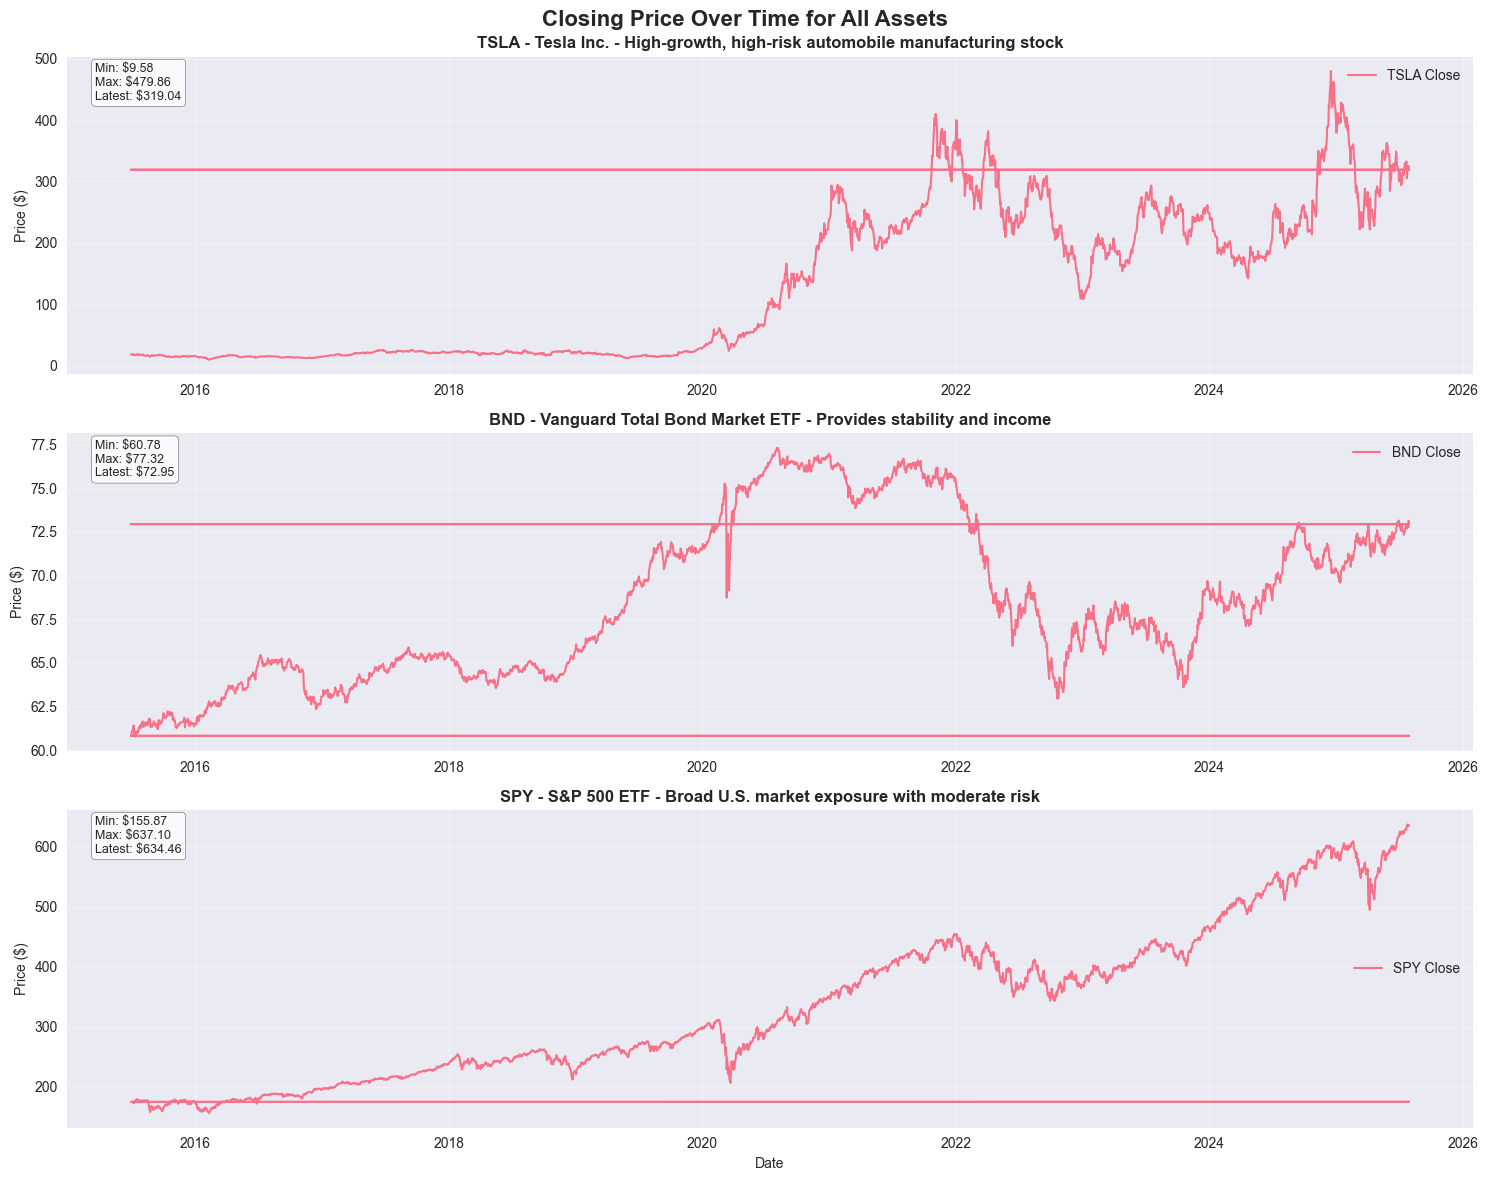

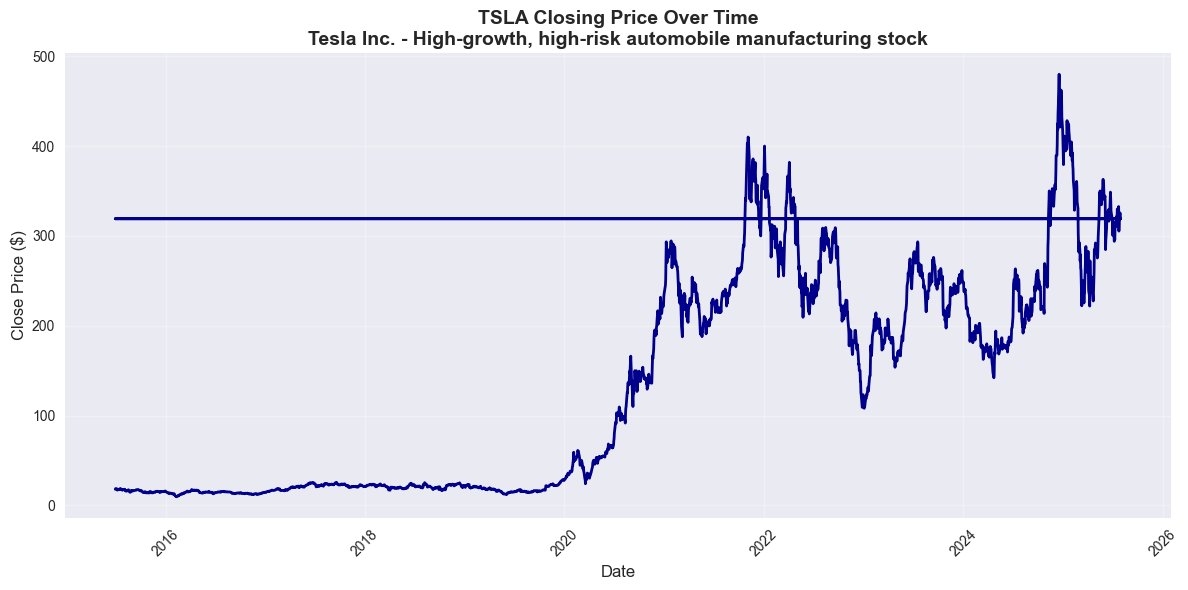

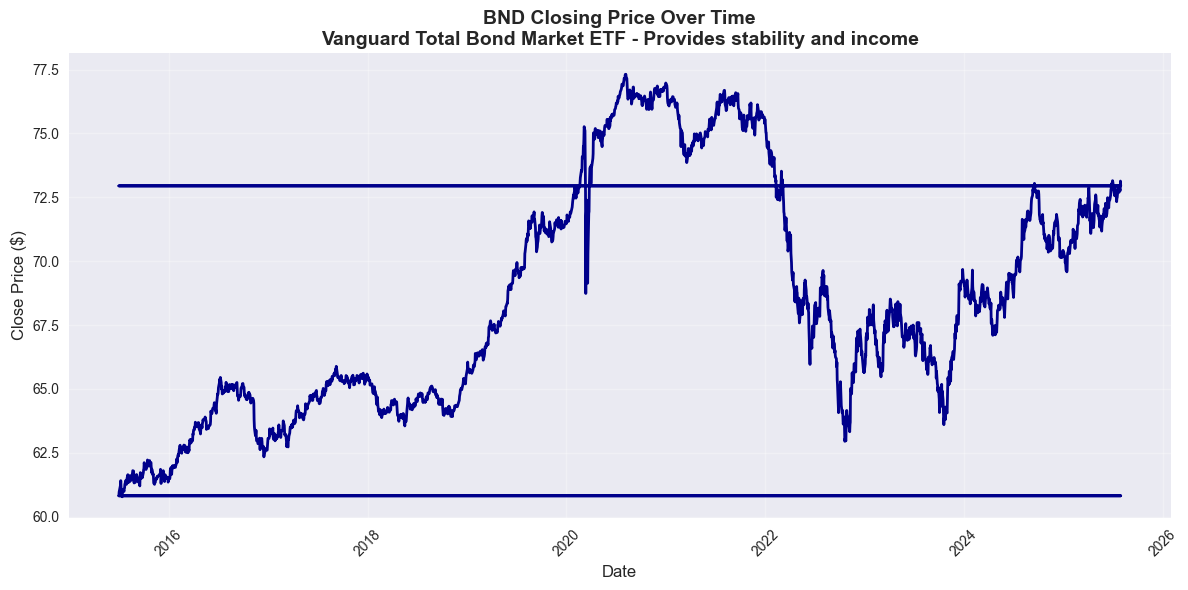

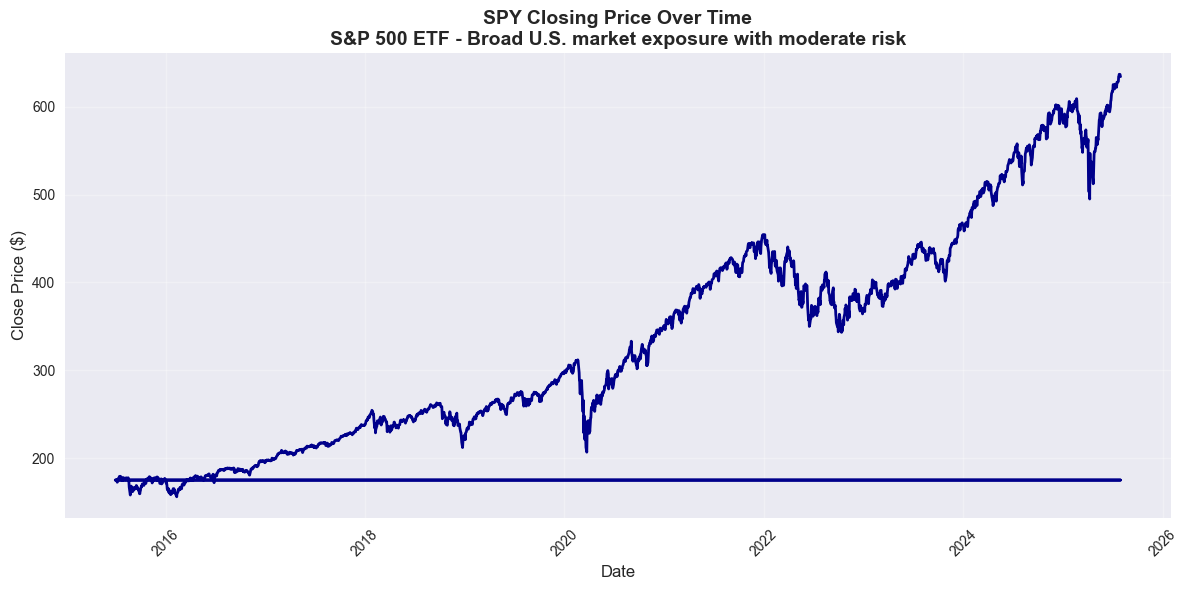

In [6]:
# Price Visualization Over Time
print("=== PRICE VISUALIZATION OVER TIME ===\n")

# Create subplots for each ticker
fig, axes = plt.subplots(len(TICKERS), 1, figsize=(15, 12))
fig.suptitle('Closing Price Over Time for All Assets', fontsize=16, fontweight='bold')

for i, ticker in enumerate(TICKERS):
    close_col = f'Close_{ticker}'
    
    if close_col in data.columns:
        axes[i].plot(data['Date'], data[close_col], linewidth=1.5, label=f'{ticker} Close')
        axes[i].set_title(f'{ticker} - {asset_info[ticker]}', fontsize=12, fontweight='bold')
        axes[i].set_ylabel('Price ($)', fontsize=10)
        axes[i].grid(True, alpha=0.3)
        axes[i].legend()
        
        # Add some statistics on the plot
        min_price = data[close_col].min()
        max_price = data[close_col].max()
        latest_price = data[close_col].iloc[-1]
        
        textstr = f'Min: ${min_price:.2f}\nMax: ${max_price:.2f}\nLatest: ${latest_price:.2f}'
        props = dict(boxstyle='round', facecolor='white', alpha=0.8)
        axes[i].text(0.02, 0.98, textstr, transform=axes[i].transAxes, fontsize=9,
                    verticalalignment='top', bbox=props)

axes[-1].set_xlabel('Date', fontsize=10)
plt.tight_layout()
plt.show()

# Individual detailed plots
for ticker in TICKERS:
    close_col = f'Close_{ticker}'
    
    if close_col in data.columns:
        plt.figure(figsize=(12, 6))
        plt.plot(data['Date'], data[close_col], linewidth=2, color='darkblue')
        plt.title(f'{ticker} Closing Price Over Time\n{asset_info[ticker]}', fontsize=14, fontweight='bold')
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Close Price ($)', fontsize=12)
        plt.grid(True, alpha=0.3)
        plt.xticks(rotation=45)
        
        # Highlight key periods or events if any significant changes
        plt.tight_layout()
        plt.show()

=== DAILY RETURNS ANALYSIS ===

TSLA Daily Returns Statistics:
  Mean: 0.0006 (0.06%)
  Std Dev: 0.0215 (2.15%)
  Min: -0.2106 (-21.06%)
  Max: 0.2269 (22.69%)

BND Daily Returns Statistics:
  Mean: 0.0000 (0.00%)
  Std Dev: 0.0020 (0.20%)
  Min: -0.0544 (-5.44%)
  Max: 0.0422 (4.22%)

SPY Daily Returns Statistics:
  Mean: 0.0002 (0.02%)
  Std Dev: 0.0066 (0.66%)
  Min: -0.1094 (-10.94%)
  Max: 0.1050 (10.50%)



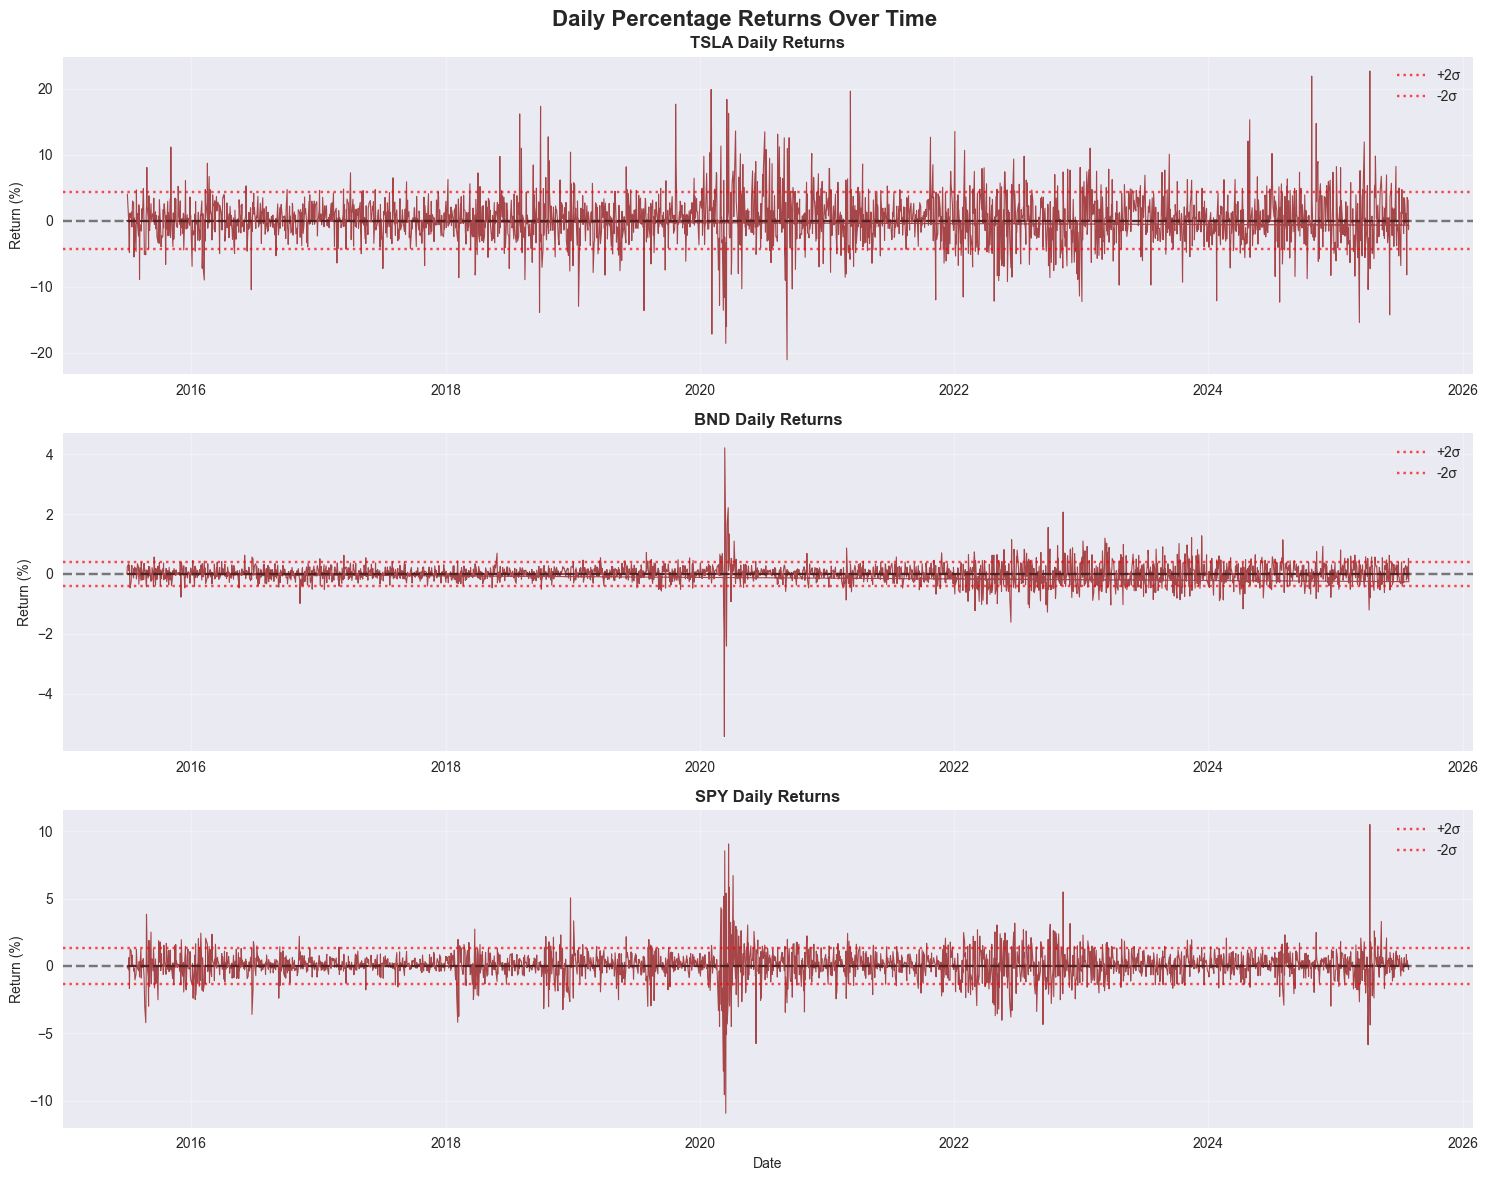

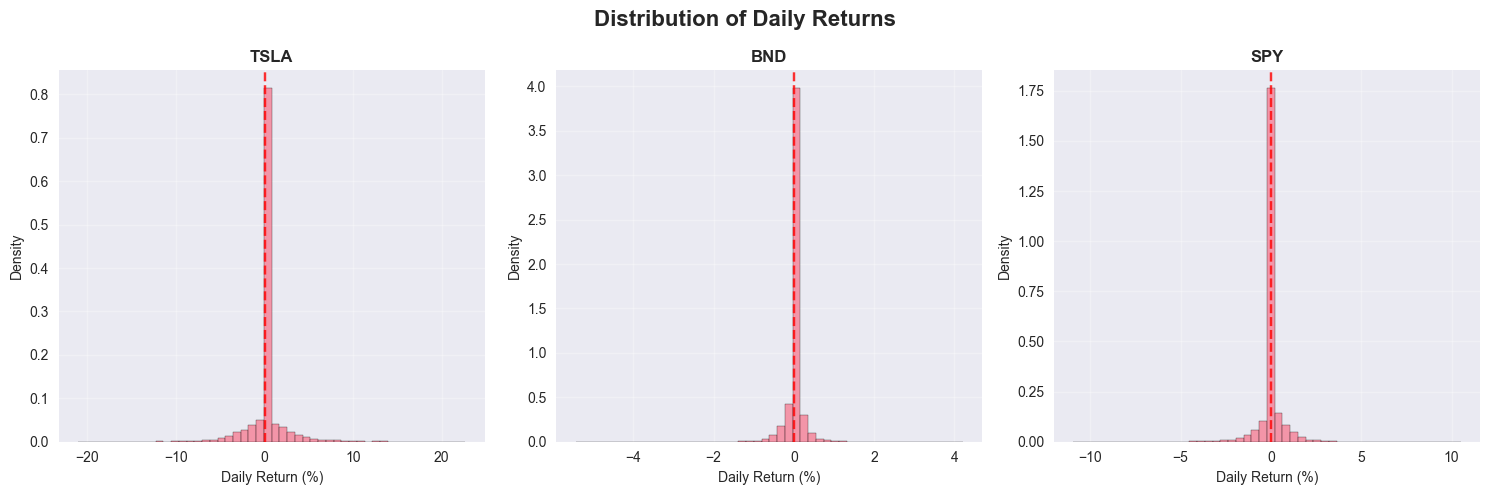

In [7]:
# Daily Returns Analysis
print("=== DAILY RETURNS ANALYSIS ===\n")

# Calculate daily percentage changes for each ticker using the wide format
returns_data = {}

for ticker in TICKERS:
    close_col = f'Close_{ticker}'
    
    # Calculate daily returns for this ticker
    daily_returns = data[close_col].pct_change()
    
    # Store the returns data
    returns_data[ticker] = {
        'Date': data['Date'],
        'Close': data[close_col],
        'Daily_Return': daily_returns
    }
    
    # Display basic return statistics
    clean_returns = daily_returns.dropna()
    print(f"{ticker} Daily Returns Statistics:")
    print(f"  Mean: {clean_returns.mean():.4f} ({clean_returns.mean()*100:.2f}%)")
    print(f"  Std Dev: {clean_returns.std():.4f} ({clean_returns.std()*100:.2f}%)")
    print(f"  Min: {clean_returns.min():.4f} ({clean_returns.min()*100:.2f}%)")
    print(f"  Max: {clean_returns.max():.4f} ({clean_returns.max()*100:.2f}%)")
    print()

# Visualization of daily returns
fig, axes = plt.subplots(len(TICKERS), 1, figsize=(15, 12))
fig.suptitle('Daily Percentage Returns Over Time', fontsize=16, fontweight='bold')

for i, ticker in enumerate(TICKERS):
    ticker_data = returns_data[ticker]
    
    axes[i].plot(ticker_data['Date'], ticker_data['Daily_Return'] * 100, 
                linewidth=0.8, alpha=0.7, color='darkred')
    axes[i].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[i].set_title(f'{ticker} Daily Returns', fontsize=12, fontweight='bold')
    axes[i].set_ylabel('Return (%)', fontsize=10)
    axes[i].grid(True, alpha=0.3)
    
    # Add volatility bands (±2 std dev)
    clean_returns = ticker_data['Daily_Return'].dropna()
    std_dev = clean_returns.std() * 100
    mean_return = clean_returns.mean() * 100
    axes[i].axhline(y=mean_return + 2*std_dev, color='red', linestyle=':', alpha=0.7, label='+2σ')
    axes[i].axhline(y=mean_return - 2*std_dev, color='red', linestyle=':', alpha=0.7, label='-2σ')
    axes[i].legend()

axes[-1].set_xlabel('Date', fontsize=10)
plt.tight_layout()
plt.show()

# Distribution of daily returns
fig, axes = plt.subplots(1, len(TICKERS), figsize=(15, 5))
fig.suptitle('Distribution of Daily Returns', fontsize=16, fontweight='bold')

for i, ticker in enumerate(TICKERS):
    ticker_data = returns_data[ticker]
    clean_returns = ticker_data['Daily_Return'].dropna()
    
    axes[i].hist(clean_returns * 100, bins=50, 
                alpha=0.7, edgecolor='black', density=True)
    axes[i].axvline(x=0, color='red', linestyle='--', alpha=0.8)
    axes[i].set_title(f'{ticker}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Daily Return (%)', fontsize=10)
    axes[i].set_ylabel('Density', fontsize=10)
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

=== VOLATILITY ANALYSIS ===

TSLA Current Volatility Metrics:
  21-day volatility: 0.00%
  63-day volatility: 0.00%
  252-day volatility: 0.00%

BND Current Volatility Metrics:
  21-day volatility: 0.00%
  63-day volatility: 0.00%
  252-day volatility: 0.00%

SPY Current Volatility Metrics:
  21-day volatility: 6.49%
  63-day volatility: 11.75%
  252-day volatility: 20.20%



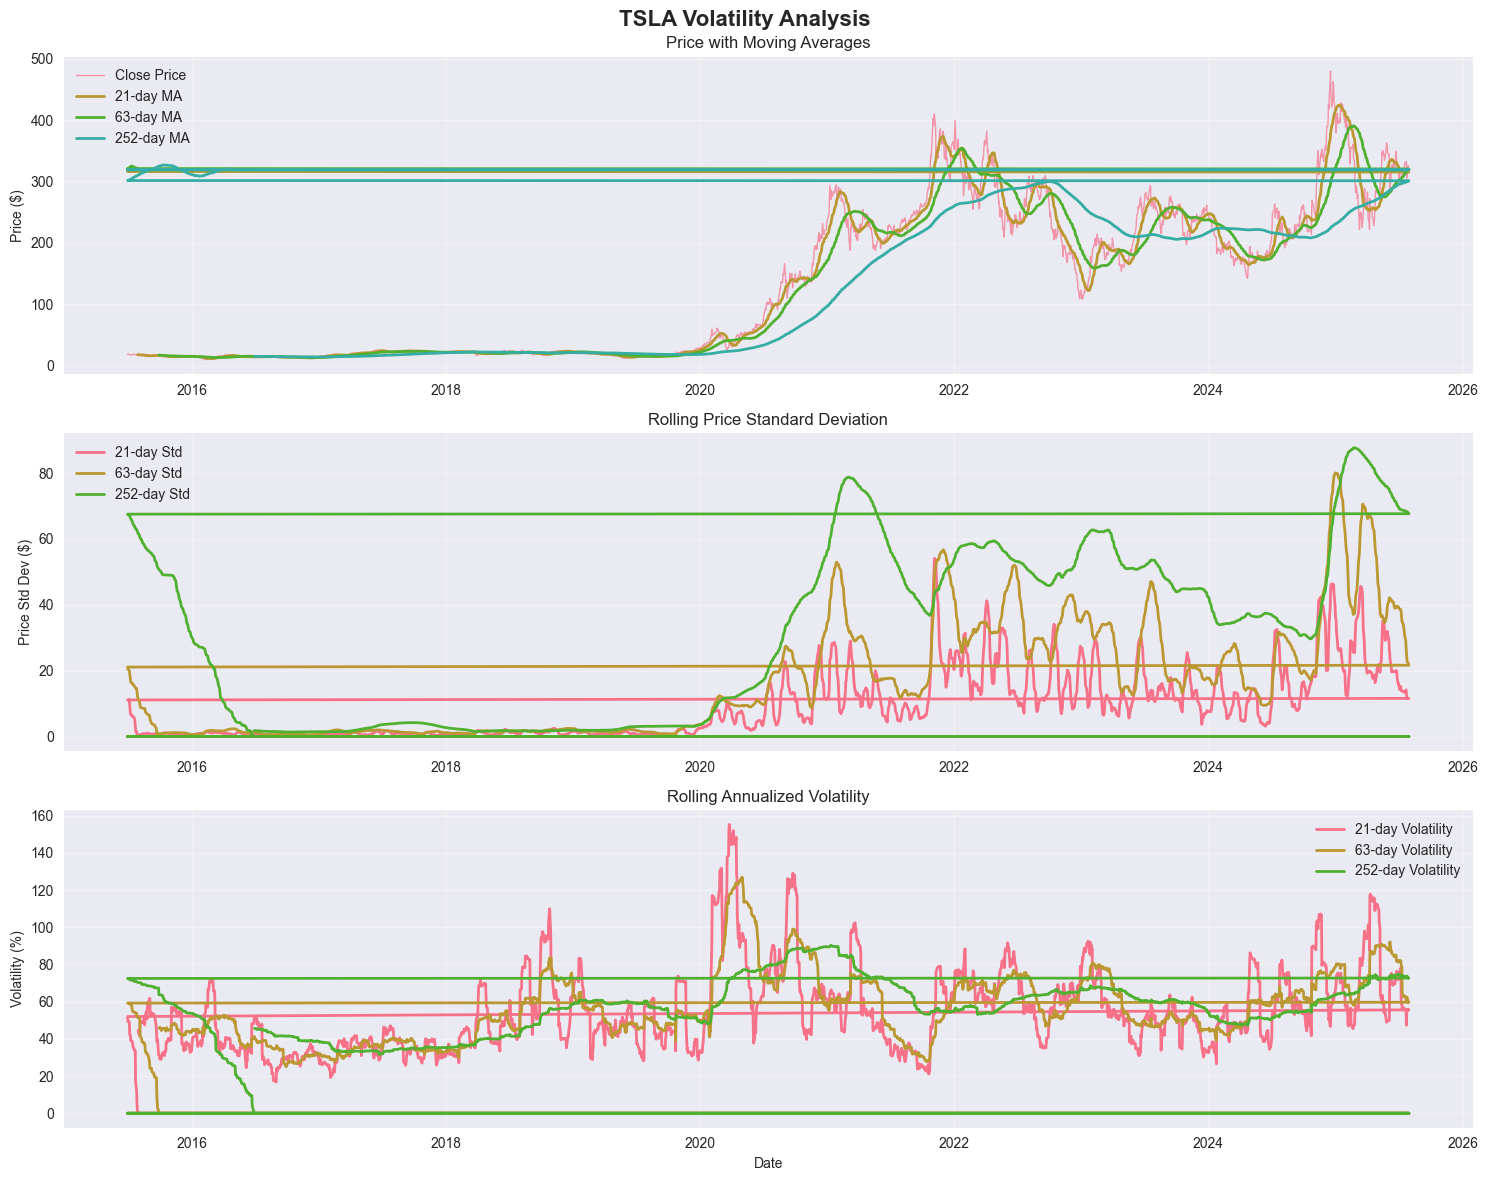

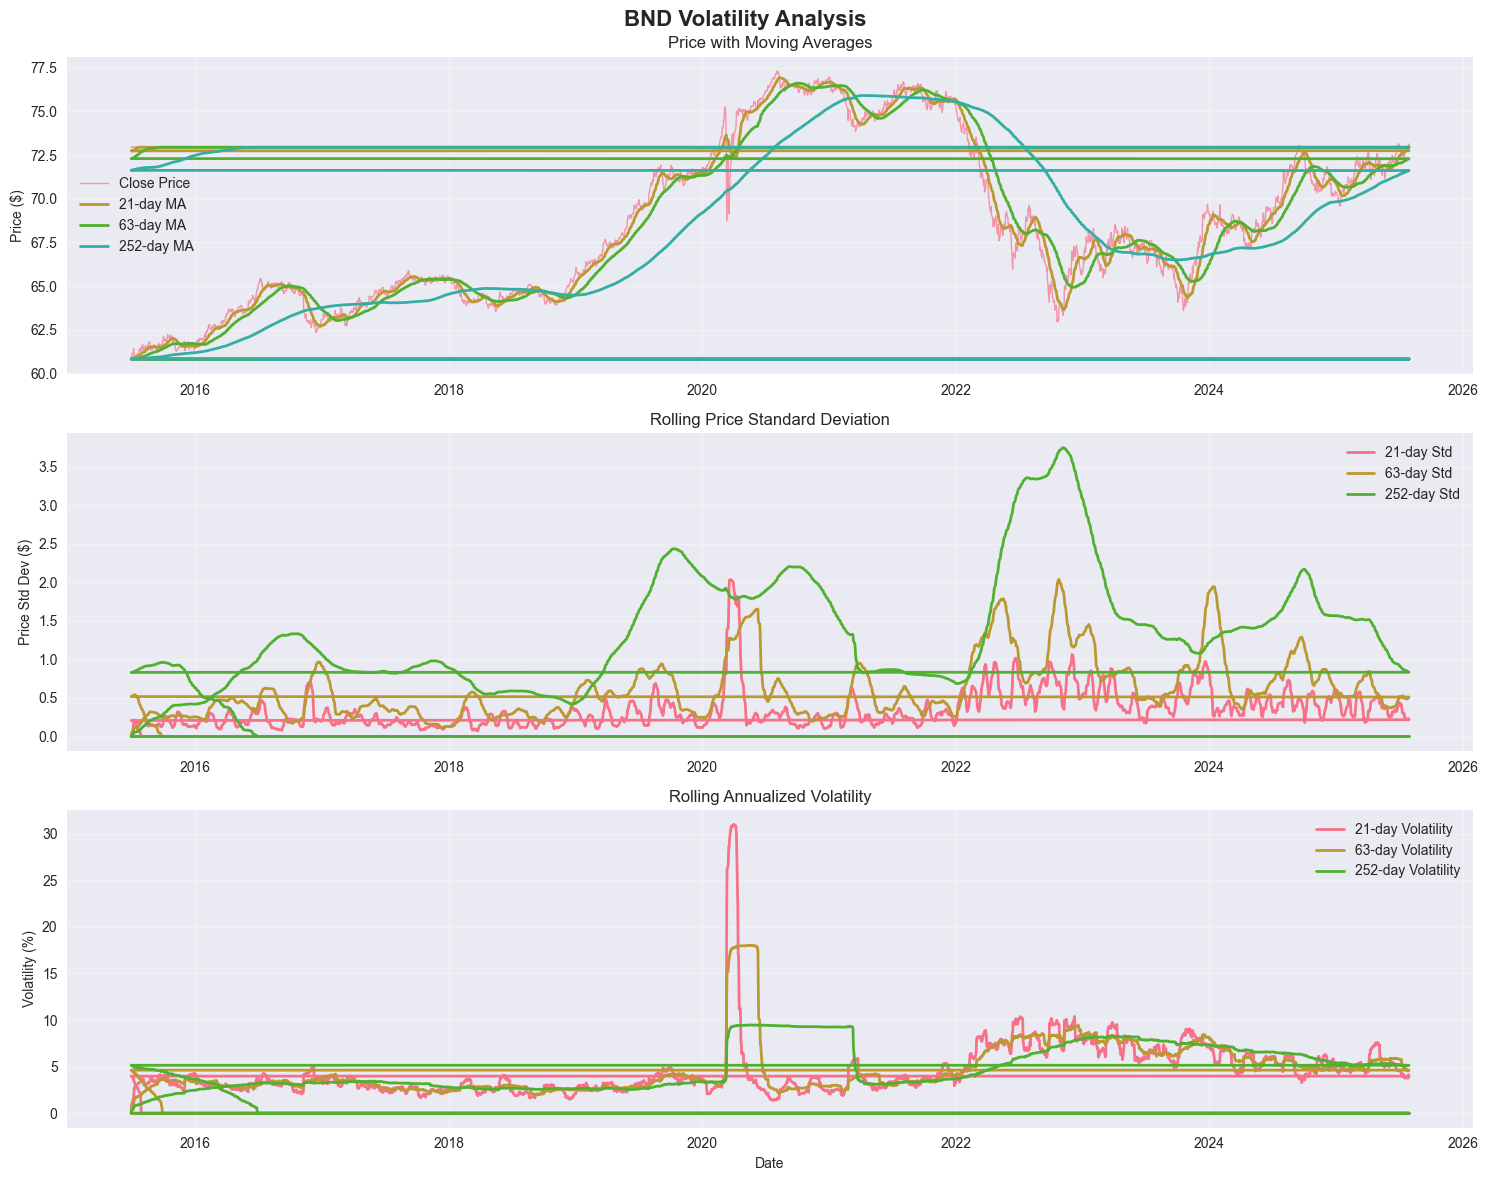

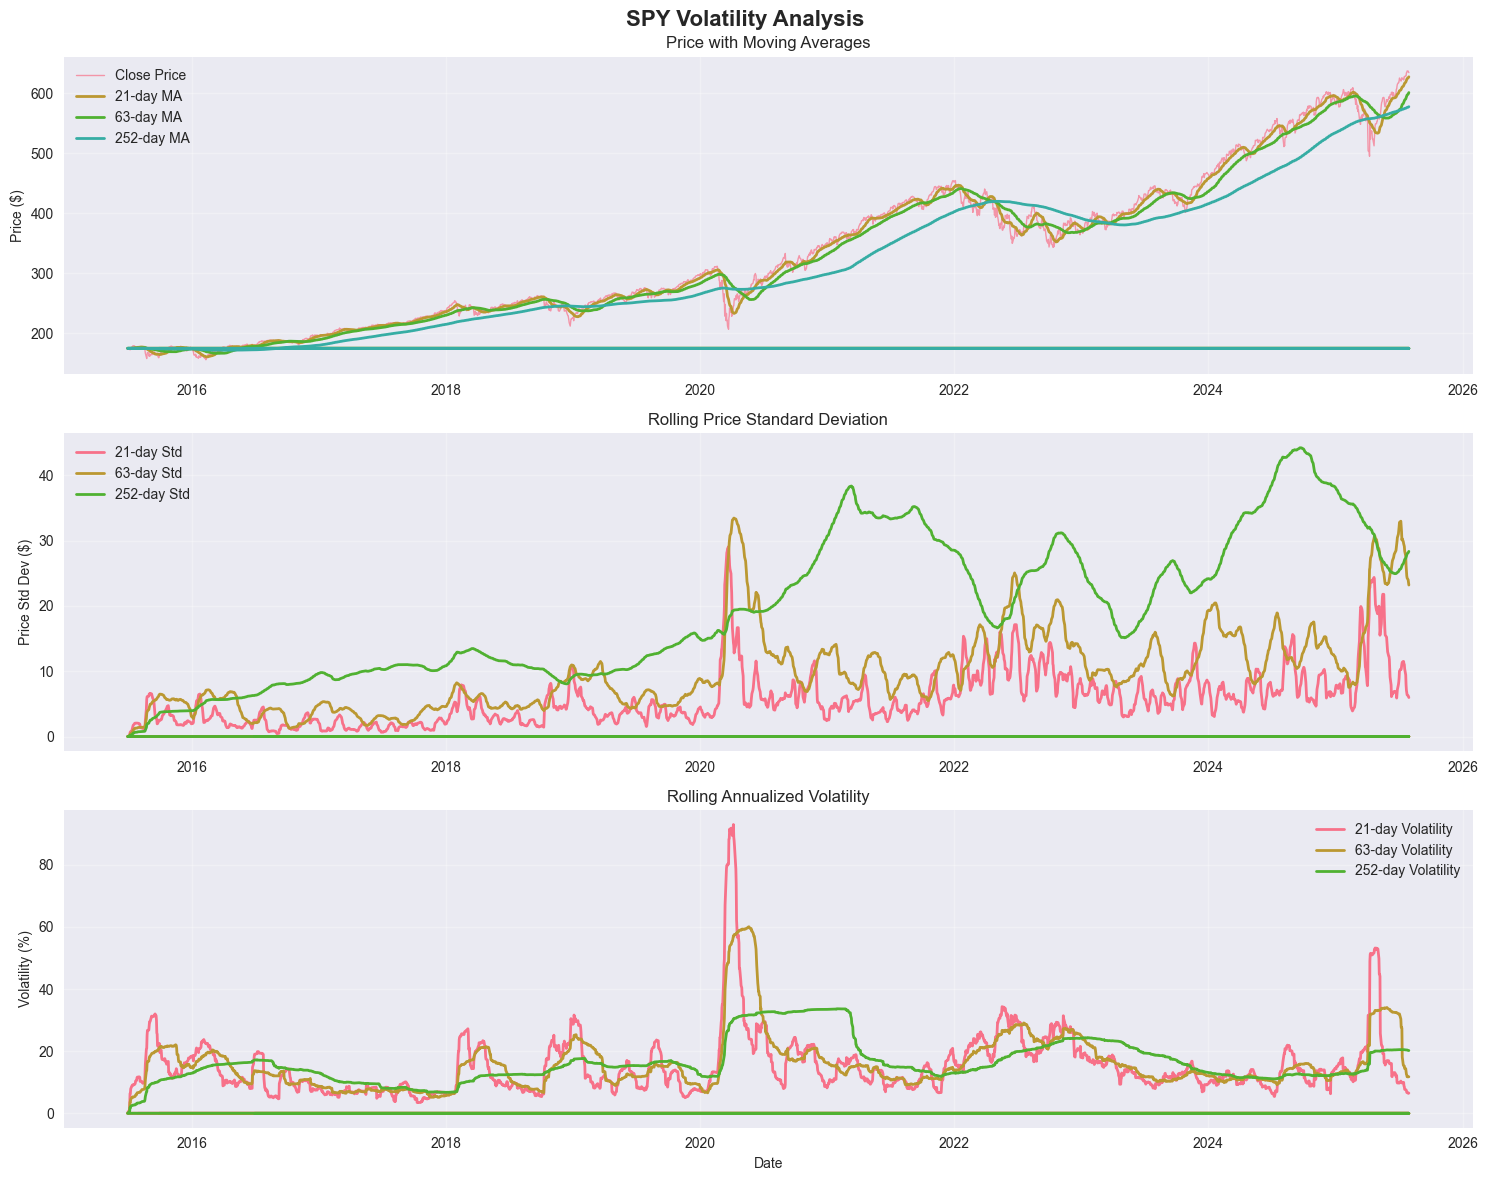

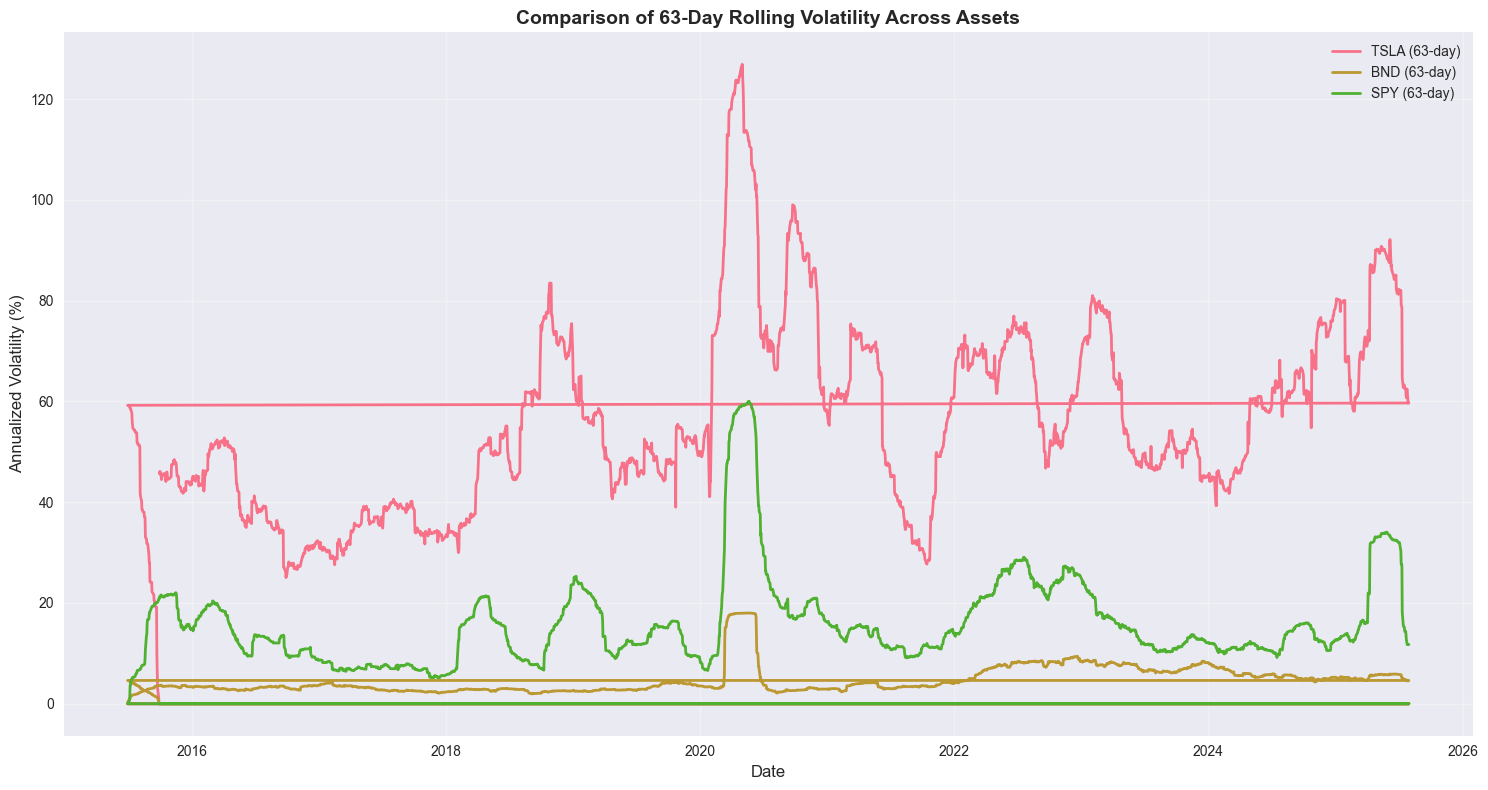

In [8]:
# Volatility Analysis with Rolling Statistics
print("=== VOLATILITY ANALYSIS ===\n")

# Define rolling windows
rolling_windows = [21, 63, 252]  # ~1 month, ~3 months, ~1 year

# Calculate rolling statistics for each ticker
volatility_data = {}

for ticker in TICKERS:
    ticker_data = returns_data[ticker].copy()
    
    # Calculate rolling means and standard deviations for different windows
    for window in rolling_windows:
        ticker_data[f'Rolling_Mean_{window}'] = ticker_data['Close'].rolling(window=window).mean()
        ticker_data[f'Rolling_Std_{window}'] = ticker_data['Close'].rolling(window=window).std()
        ticker_data[f'Rolling_Volatility_{window}'] = ticker_data['Daily_Return'].rolling(window=window).std() * np.sqrt(252) * 100
    
    volatility_data[ticker] = ticker_data
    
    print(f"{ticker} Current Volatility Metrics:")
    print(f"  21-day volatility: {ticker_data[f'Rolling_Volatility_21'].iloc[-1]:.2f}%")
    print(f"  63-day volatility: {ticker_data[f'Rolling_Volatility_63'].iloc[-1]:.2f}%")
    print(f"  252-day volatility: {ticker_data[f'Rolling_Volatility_252'].iloc[-1]:.2f}%")
    print()

# Visualize rolling statistics
for ticker in TICKERS:
    ticker_data = volatility_data[ticker]
    
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))
    fig.suptitle(f'{ticker} Volatility Analysis', fontsize=16, fontweight='bold')
    
    # Price with rolling means
    ax1.plot(ticker_data['Date'], ticker_data['Close'], label='Close Price', alpha=0.7, linewidth=1)
    ax1.plot(ticker_data['Date'], ticker_data['Rolling_Mean_21'], label='21-day MA', linewidth=2)
    ax1.plot(ticker_data['Date'], ticker_data['Rolling_Mean_63'], label='63-day MA', linewidth=2)
    ax1.plot(ticker_data['Date'], ticker_data['Rolling_Mean_252'], label='252-day MA', linewidth=2)
    ax1.set_title('Price with Moving Averages', fontsize=12)
    ax1.set_ylabel('Price ($)', fontsize=10)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Rolling standard deviation (price volatility)
    ax2.plot(ticker_data['Date'], ticker_data['Rolling_Std_21'], label='21-day Std', linewidth=2)
    ax2.plot(ticker_data['Date'], ticker_data['Rolling_Std_63'], label='63-day Std', linewidth=2)
    ax2.plot(ticker_data['Date'], ticker_data['Rolling_Std_252'], label='252-day Std', linewidth=2)
    ax2.set_title('Rolling Price Standard Deviation', fontsize=12)
    ax2.set_ylabel('Price Std Dev ($)', fontsize=10)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Rolling volatility (annualized)
    ax3.plot(ticker_data['Date'], ticker_data['Rolling_Volatility_21'], label='21-day Volatility', linewidth=2)
    ax3.plot(ticker_data['Date'], ticker_data['Rolling_Volatility_63'], label='63-day Volatility', linewidth=2)
    ax3.plot(ticker_data['Date'], ticker_data['Rolling_Volatility_252'], label='252-day Volatility', linewidth=2)
    ax3.set_title('Rolling Annualized Volatility', fontsize=12)
    ax3.set_ylabel('Volatility (%)', fontsize=10)
    ax3.set_xlabel('Date', fontsize=10)
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Compare volatilities across assets
plt.figure(figsize=(15, 8))
for ticker in TICKERS:
    ticker_data = volatility_data[ticker]
    plt.plot(ticker_data['Date'], ticker_data['Rolling_Volatility_63'], 
             label=f'{ticker} (63-day)', linewidth=2)

plt.title('Comparison of 63-Day Rolling Volatility Across Assets', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Annualized Volatility (%)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

=== OUTLIER DETECTION USING Z-SCORE ===

TSLA Outlier Analysis:
  Total outliers (|Z-score| > 3): 199
  Percentage of data points: 2.62%
  Most extreme outlier:
    Date: 2025-04-09
    Return: 22.69%
    Z-score: 10.51
    Close price: $272.20

BND Outlier Analysis:
  Total outliers (|Z-score| > 3): 153
  Percentage of data points: 2.01%
  Most extreme outlier:
    Date: 2020-03-12
    Return: -5.44%
    Z-score: 27.24
    Close price: $68.74

SPY Outlier Analysis:
  Total outliers (|Z-score| > 3): 163
  Percentage of data points: 2.14%
  Most extreme outlier:
    Date: 2020-03-16
    Return: -10.94%
    Z-score: 16.51
    Close price: $221.05



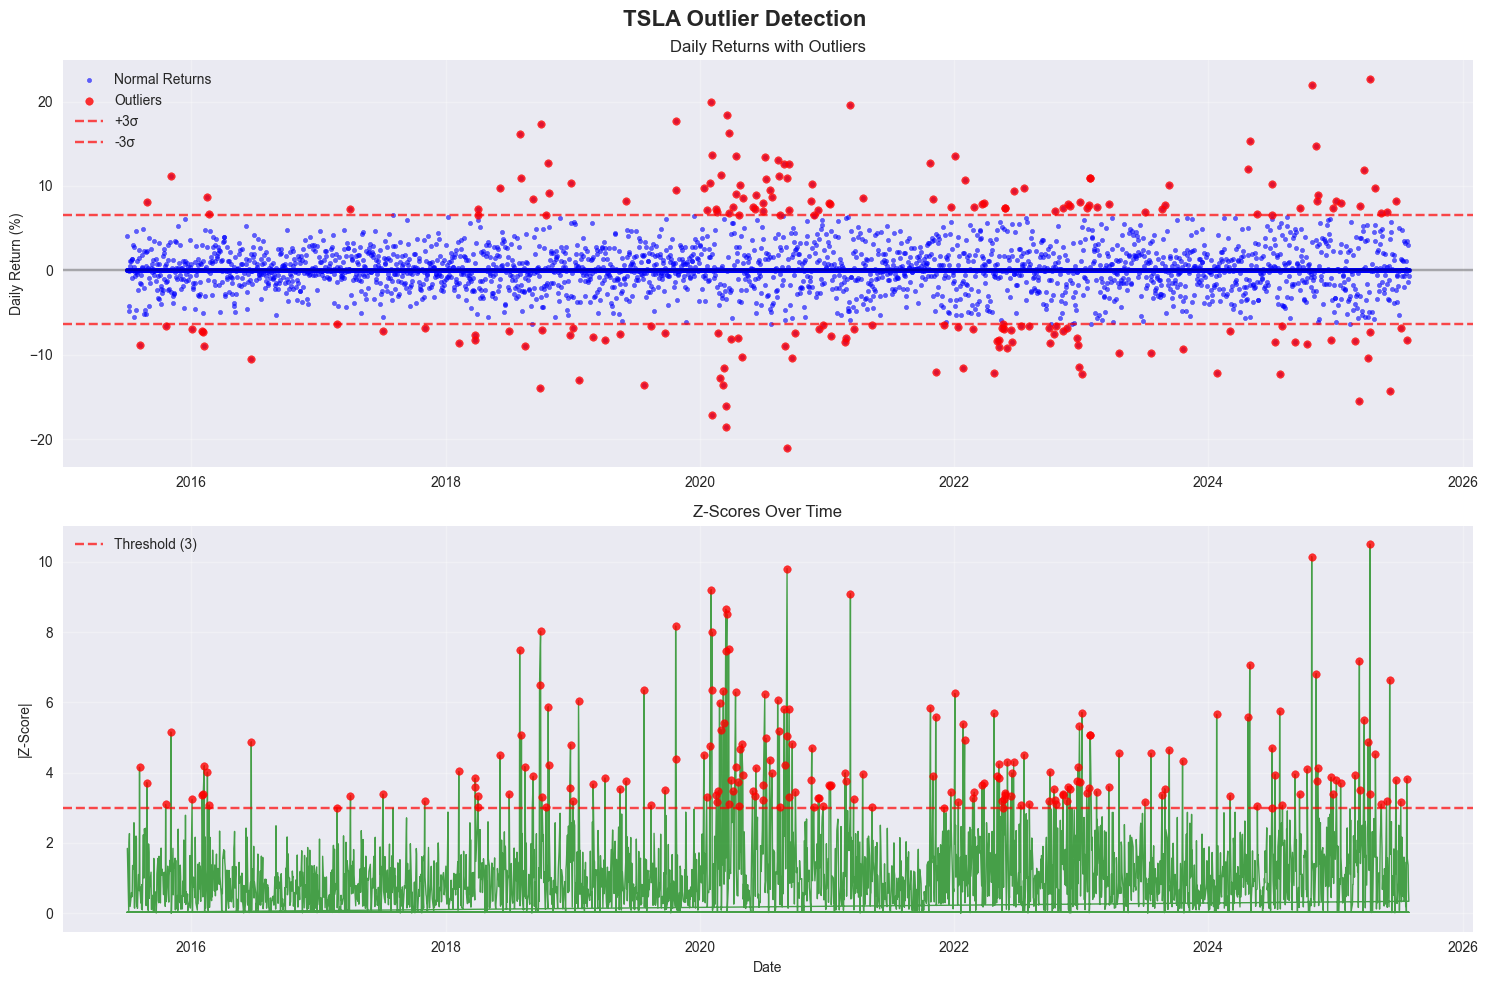

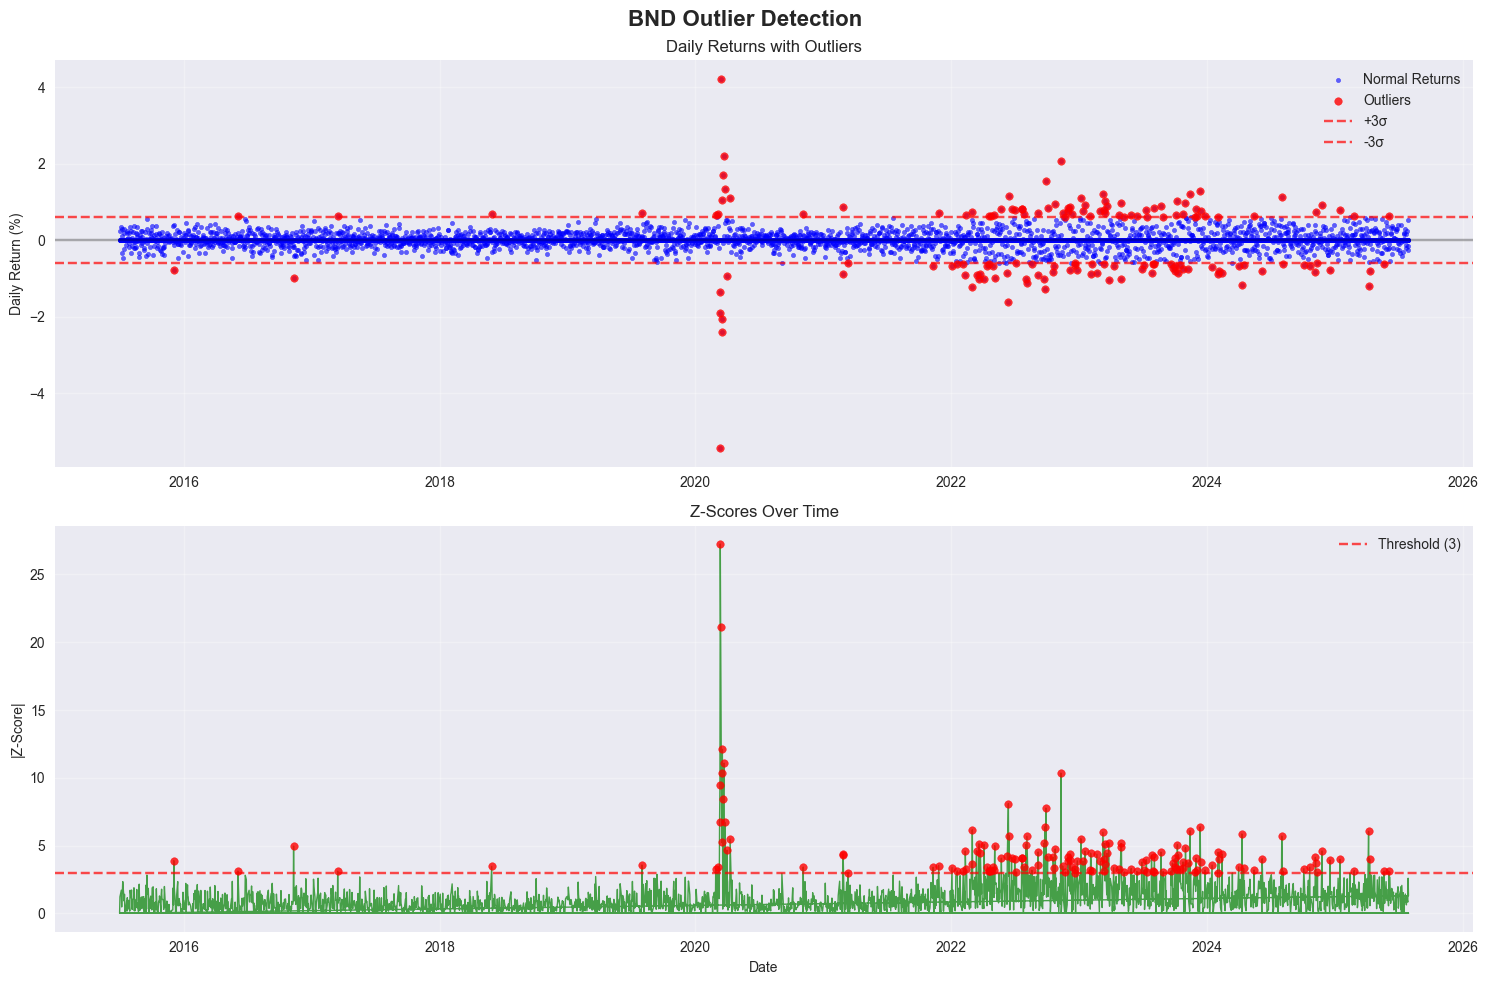

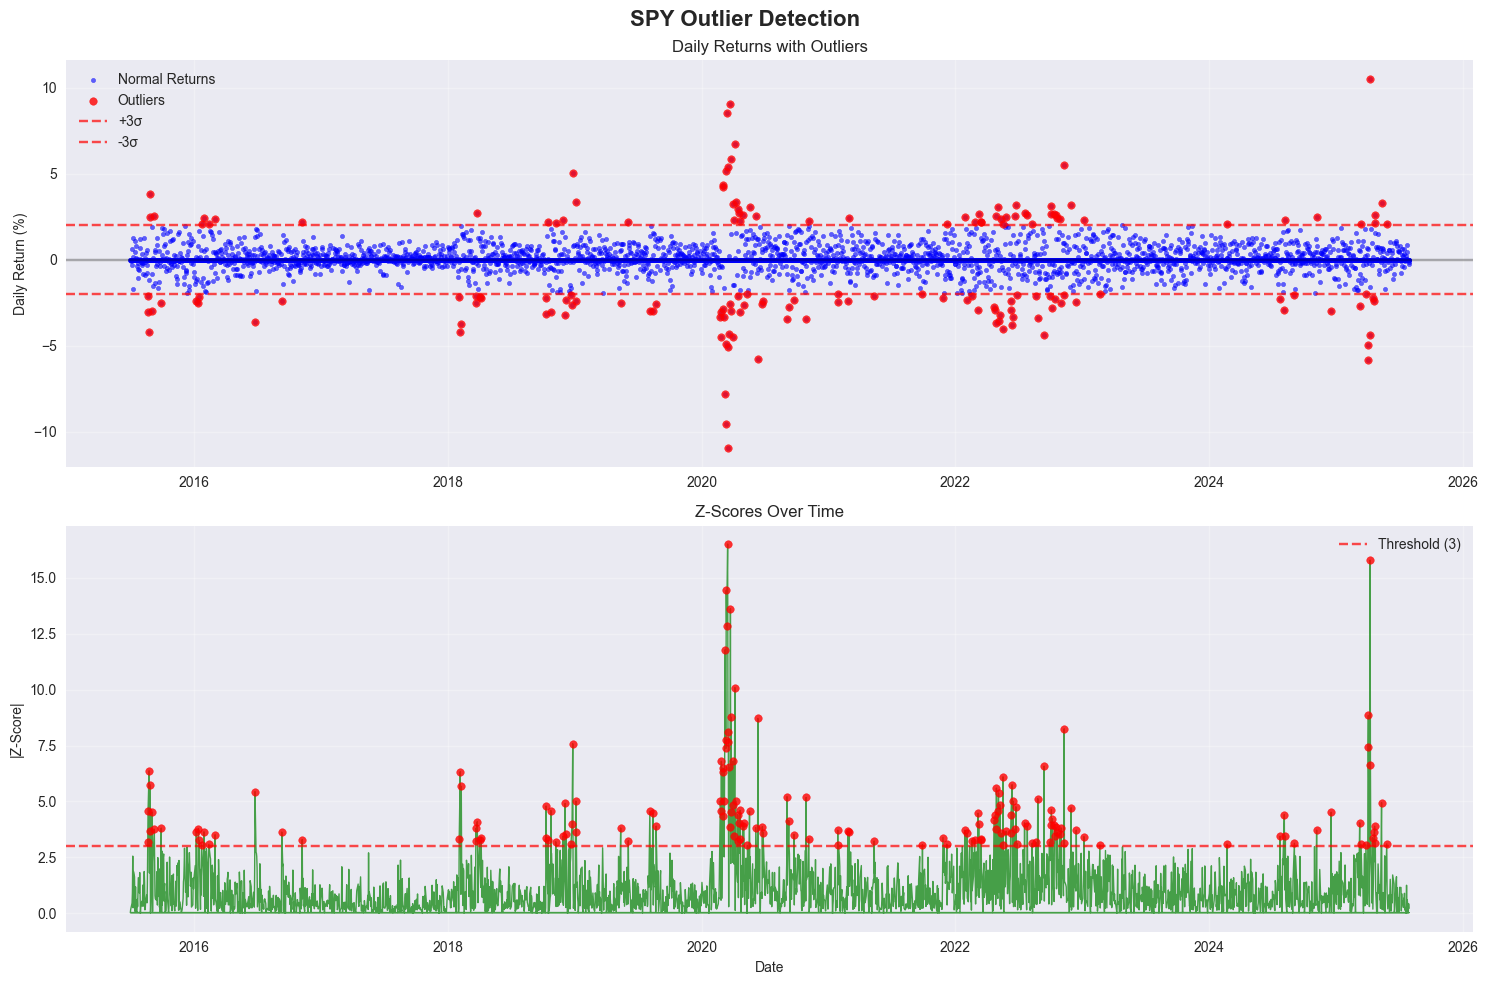

Top 5 Outliers by Z-Score for Each Asset:

TSLA:
      Date Daily_Return Z_Score   Close
2025-04-09       22.69%   10.51 $272.20
2024-10-24       21.92%   10.15 $260.48
2020-09-08      -21.06%    9.81 $110.07
2020-02-03       19.89%    9.21  $52.00
2021-03-09       19.64%    9.09 $224.53

BND:
      Date Daily_Return Z_Score  Close
2020-03-12       -5.44%   27.24 $68.74
2020-03-13        4.22%   21.12 $71.64
2020-03-18       -2.41%   12.10 $69.18
2020-03-23        2.21%   11.08 $71.87
2020-03-17       -2.07%   10.37 $70.89

SPY:
      Date Daily_Return Z_Score   Close
2020-03-16      -10.94%   16.51 $221.05
2025-04-09       10.50%   15.79 $547.00
2020-03-12       -9.57%   14.44 $228.66
2020-03-24        9.06%   13.62 $225.41
2020-03-13        8.55%   12.85 $248.21


In [9]:
# Outlier Detection Using Z-Score
print("=== OUTLIER DETECTION USING Z-SCORE ===\n")

# Detect outliers using Z-score (threshold = 3)
outlier_threshold = 3
outlier_results = {}

for ticker in TICKERS:
    # Create a proper DataFrame for this ticker's data
    ticker_data = pd.DataFrame({
        'Date': returns_data[ticker]['Date'],
        'Close': returns_data[ticker]['Close'],
        'Daily_Return': returns_data[ticker]['Daily_Return']
    })
    
    # Calculate Z-scores for daily returns
    clean_returns = ticker_data['Daily_Return'].dropna()
    ticker_data['Z_Score'] = np.abs((ticker_data['Daily_Return'] - clean_returns.mean()) / clean_returns.std())
    
    # Identify outliers
    outliers = ticker_data[ticker_data['Z_Score'] > outlier_threshold].copy()
    outlier_results[ticker] = outliers
    
    print(f"{ticker} Outlier Analysis:")
    print(f"  Total outliers (|Z-score| > {outlier_threshold}): {len(outliers)}")
    print(f"  Percentage of data points: {len(outliers)/len(ticker_data)*100:.2f}%")
    
    if len(outliers) > 0:
        print(f"  Most extreme outlier:")
        extreme_outlier = outliers.loc[outliers['Z_Score'].idxmax()]
        print(f"    Date: {extreme_outlier['Date'].strftime('%Y-%m-%d')}")
        print(f"    Return: {extreme_outlier['Daily_Return']*100:.2f}%")
        print(f"    Z-score: {extreme_outlier['Z_Score']:.2f}")
        print(f"    Close price: ${extreme_outlier['Close']:.2f}")
    print()

# Visualize outliers
for ticker in TICKERS:
    ticker_data = pd.DataFrame({
        'Date': returns_data[ticker]['Date'],
        'Close': returns_data[ticker]['Close'],
        'Daily_Return': returns_data[ticker]['Daily_Return']
    })
    
    # Recalculate Z-scores for visualization
    clean_returns = ticker_data['Daily_Return'].dropna()
    ticker_data['Z_Score'] = np.abs((ticker_data['Daily_Return'] - clean_returns.mean()) / clean_returns.std())
    outliers = outlier_results[ticker]
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
    fig.suptitle(f'{ticker} Outlier Detection', fontsize=16, fontweight='bold')
    
    # Daily returns with outliers highlighted
    ax1.scatter(ticker_data['Date'], ticker_data['Daily_Return'] * 100, 
               alpha=0.6, s=10, color='blue', label='Normal Returns')
    if len(outliers) > 0:
        ax1.scatter(outliers['Date'], outliers['Daily_Return'] * 100, 
                   color='red', s=30, alpha=0.8, label='Outliers', zorder=5)
    
    # Add threshold lines
    mean_return = clean_returns.mean() * 100
    std_return = clean_returns.std() * 100
    ax1.axhline(y=mean_return + outlier_threshold * std_return, 
               color='red', linestyle='--', alpha=0.7, label=f'+{outlier_threshold}σ')
    ax1.axhline(y=mean_return - outlier_threshold * std_return, 
               color='red', linestyle='--', alpha=0.7, label=f'-{outlier_threshold}σ')
    ax1.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    ax1.set_title('Daily Returns with Outliers', fontsize=12)
    ax1.set_ylabel('Daily Return (%)', fontsize=10)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Z-scores over time
    ax2.plot(ticker_data['Date'], ticker_data['Z_Score'], color='green', alpha=0.7, linewidth=1)
    ax2.axhline(y=outlier_threshold, color='red', linestyle='--', alpha=0.7, 
               label=f'Threshold ({outlier_threshold})')
    if len(outliers) > 0:
        ax2.scatter(outliers['Date'], outliers['Z_Score'], 
                   color='red', s=30, alpha=0.8, zorder=5)
    
    ax2.set_title('Z-Scores Over Time', fontsize=12)
    ax2.set_ylabel('|Z-Score|', fontsize=10)
    ax2.set_xlabel('Date', fontsize=10)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Summary table of top outliers
print("Top 5 Outliers by Z-Score for Each Asset:")
print("="*60)
for ticker in TICKERS:
    outliers = outlier_results[ticker]
    if len(outliers) > 0:
        top_outliers = outliers.nlargest(5, 'Z_Score')[['Date', 'Daily_Return', 'Z_Score', 'Close']]
        top_outliers = top_outliers.copy()
        top_outliers['Daily_Return'] = top_outliers['Daily_Return'] * 100
        print(f"\n{ticker}:")
        print(top_outliers.to_string(index=False, 
                                    formatters={'Daily_Return': '{:.2f}%'.format,
                                              'Z_Score': '{:.2f}'.format,
                                              'Close': '${:.2f}'.format}))

=== EXTREME RETURNS ANALYSIS ===

TSLA Extreme Returns Analysis:
  Return percentiles:
    P1: -6.81%
    P5: -2.94%
    P95: 3.27%
    P99: 7.49%
  Extreme high returns (>99th percentile): 77 days
  Extreme low returns (<1st percentile): 77 days
  Worst day: 2020-09-08 (-21.06%)
  Best day: 2025-04-09 (22.69%)

BND Extreme Returns Analysis:
  Return percentiles:
    P1: -0.59%
    P5: -0.26%
    P95: 0.27%
    P99: 0.60%
  Extreme high returns (>99th percentile): 77 days
  Extreme low returns (<1st percentile): 77 days
  Worst day: 2020-03-12 (-5.44%)
  Best day: 2020-03-13 (4.22%)

SPY Extreme Returns Analysis:
  Return percentiles:
    P1: -2.18%
    P5: -0.76%
    P95: 0.94%
    P99: 1.94%
  Extreme high returns (>99th percentile): 77 days
  Extreme low returns (<1st percentile): 77 days
  Worst day: 2020-03-16 (-10.94%)
  Best day: 2025-04-09 (10.50%)



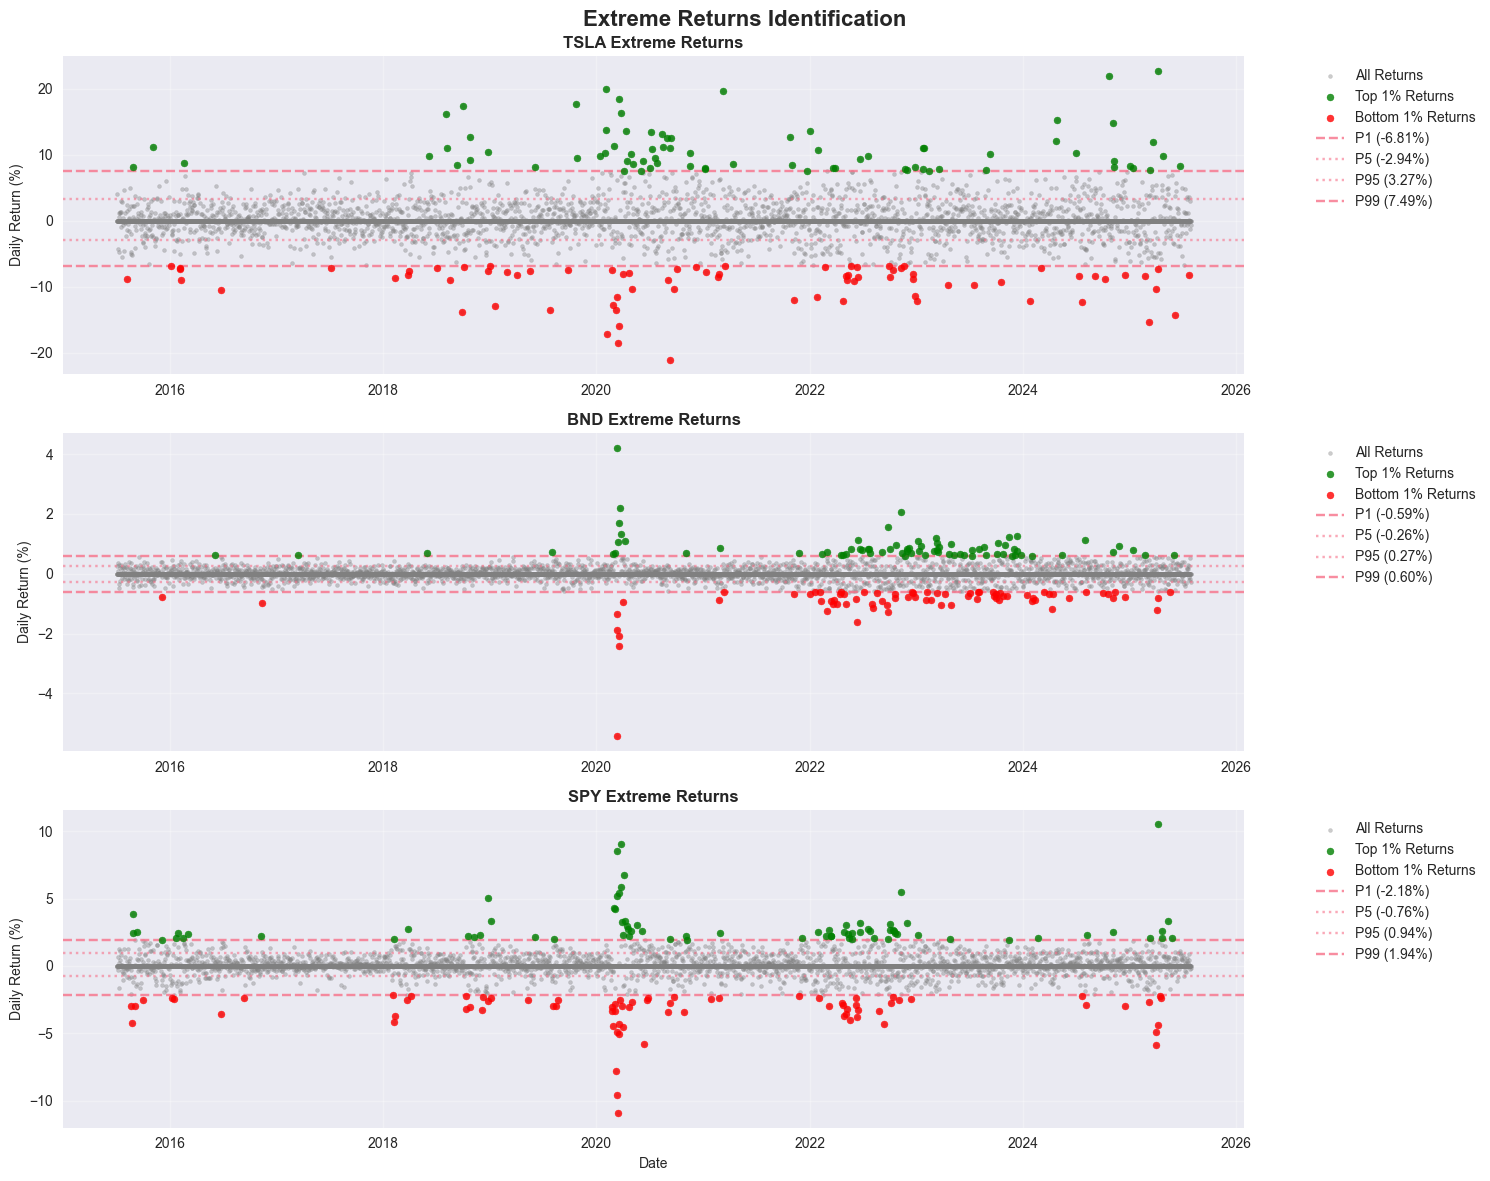

Summary of Extreme Return Events:

TSLA - Top 5 Best and Worst Days:

Best Days (Highest Returns):
  2025-04-09: +22.69% (Close: $272.20)
  2024-10-24: +21.92% (Close: $260.48)
  2020-02-03: +19.89% (Close: $52.00)
  2021-03-09: +19.64% (Close: $224.53)
  2020-03-19: +18.39% (Close: $28.51)

Worst Days (Lowest Returns):
  2020-09-08: -21.06% (Close: $110.07)
  2020-03-16: -18.58% (Close: $29.67)
  2020-02-05: -17.18% (Close: $48.98)
  2020-03-18: -16.03% (Close: $24.08)
  2025-03-10: -15.43% (Close: $222.15)

BND - Top 5 Best and Worst Days:

Best Days (Highest Returns):
  2020-03-13: +4.22% (Close: $71.64)
  2020-03-23: +2.21% (Close: $71.87)
  2022-11-10: +2.07% (Close: $65.02)
  2020-03-20: +1.70% (Close: $70.31)
  2022-09-28: +1.55% (Close: $65.07)

Worst Days (Lowest Returns):
  2020-03-12: -5.44% (Close: $68.74)
  2020-03-18: -2.41% (Close: $69.18)
  2020-03-17: -2.07% (Close: $70.89)
  2020-03-11: -1.89% (Close: $72.69)
  2022-06-13: -1.62% (Close: $66.32)

SPY - Top 5 Best and 

In [10]:
# Extreme Returns Identification
print("=== EXTREME RETURNS ANALYSIS ===\n")

# Define percentiles for extreme returns
extreme_percentiles = [1, 5, 95, 99]  # Bottom 1%, 5% and top 95%, 99%

extreme_returns_summary = {}

for ticker in TICKERS:
    # Create a proper DataFrame for this ticker's data
    ticker_data = pd.DataFrame({
        'Date': returns_data[ticker]['Date'],
        'Close': returns_data[ticker]['Close'],
        'Daily_Return': returns_data[ticker]['Daily_Return']
    })
    
    # Calculate percentiles
    percentiles = {}
    clean_returns = ticker_data['Daily_Return'].dropna()
    for p in extreme_percentiles:
        percentiles[f'P{p}'] = clean_returns.quantile(p/100)
    
    # Identify extreme returns
    extreme_high = ticker_data[ticker_data['Daily_Return'] > percentiles['P99']]
    extreme_low = ticker_data[ticker_data['Daily_Return'] < percentiles['P1']]
    high_volatility = ticker_data[ticker_data['Daily_Return'] > percentiles['P95']]
    low_volatility = ticker_data[ticker_data['Daily_Return'] < percentiles['P5']]
    
    extreme_returns_summary[ticker] = {
        'percentiles': percentiles,
        'extreme_high': extreme_high,
        'extreme_low': extreme_low,
        'high_volatility': high_volatility,
        'low_volatility': low_volatility
    }
    
    print(f"{ticker} Extreme Returns Analysis:")
    print(f"  Return percentiles:")
    for p_name, p_value in percentiles.items():
        print(f"    {p_name}: {p_value*100:.2f}%")
    print(f"  Extreme high returns (>99th percentile): {len(extreme_high)} days")
    print(f"  Extreme low returns (<1st percentile): {len(extreme_low)} days")
    
    # Show worst and best days
    if len(extreme_low) > 0:
        worst_day = extreme_low.loc[extreme_low['Daily_Return'].idxmin()]
        print(f"  Worst day: {worst_day['Date'].strftime('%Y-%m-%d')} ({worst_day['Daily_Return']*100:.2f}%)")
    
    if len(extreme_high) > 0:
        best_day = extreme_high.loc[extreme_high['Daily_Return'].idxmax()]
        print(f"  Best day: {best_day['Date'].strftime('%Y-%m-%d')} ({best_day['Daily_Return']*100:.2f}%)")
    print()

# Visualize extreme returns
fig, axes = plt.subplots(len(TICKERS), 1, figsize=(15, 12))
fig.suptitle('Extreme Returns Identification', fontsize=16, fontweight='bold')

for i, ticker in enumerate(TICKERS):
    # Recreate ticker_data for visualization
    ticker_data = pd.DataFrame({
        'Date': returns_data[ticker]['Date'],
        'Close': returns_data[ticker]['Close'],
        'Daily_Return': returns_data[ticker]['Daily_Return']
    })
    summary = extreme_returns_summary[ticker]
    
    # Plot daily returns
    axes[i].scatter(ticker_data['Date'], ticker_data['Daily_Return'] * 100, 
                   alpha=0.4, s=8, color='gray', label='All Returns')
    
    # Highlight extreme returns
    if len(summary['extreme_high']) > 0:
        axes[i].scatter(summary['extreme_high']['Date'], 
                       summary['extreme_high']['Daily_Return'] * 100,
                       color='green', s=25, alpha=0.8, label='Top 1% Returns', zorder=5)
    
    if len(summary['extreme_low']) > 0:
        axes[i].scatter(summary['extreme_low']['Date'], 
                       summary['extreme_low']['Daily_Return'] * 100,
                       color='red', s=25, alpha=0.8, label='Bottom 1% Returns', zorder=5)
    
    # Add percentile lines
    for p_name, p_value in summary['percentiles'].items():
        line_style = '--' if p_name in ['P1', 'P99'] else ':'
        alpha = 0.8 if p_name in ['P1', 'P99'] else 0.6
        axes[i].axhline(y=p_value * 100, linestyle=line_style, alpha=alpha,
                       label=f'{p_name} ({p_value*100:.2f}%)')
    
    axes[i].set_title(f'{ticker} Extreme Returns', fontsize=12, fontweight='bold')
    axes[i].set_ylabel('Daily Return (%)', fontsize=10)
    axes[i].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[i].grid(True, alpha=0.3)

axes[-1].set_xlabel('Date', fontsize=10)
plt.tight_layout()
plt.show()

# Create a summary table of extreme return events
print("Summary of Extreme Return Events:")
print("="*50)

for ticker in TICKERS:
    summary = extreme_returns_summary[ticker]
    
    print(f"\n{ticker} - Top 5 Best and Worst Days:")
    
    # Best days
    if len(summary['extreme_high']) > 0:
        best_days = summary['extreme_high'].nlargest(5, 'Daily_Return')[['Date', 'Daily_Return', 'Close']]
        print("\nBest Days (Highest Returns):")
        for _, row in best_days.iterrows():
            print(f"  {row['Date'].strftime('%Y-%m-%d')}: {row['Daily_Return']*100:+.2f}% (Close: ${row['Close']:.2f})")
    
    # Worst days
    if len(summary['extreme_low']) > 0:
        worst_days = summary['extreme_low'].nsmallest(5, 'Daily_Return')[['Date', 'Daily_Return', 'Close']]
        print("\nWorst Days (Lowest Returns):")
        for _, row in worst_days.iterrows():
            print(f"  {row['Date'].strftime('%Y-%m-%d')}: {row['Daily_Return']*100:+.2f}% (Close: ${row['Close']:.2f})")

# Extreme returns frequency analysis
print(f"\n{'='*60}")
print("Extreme Returns Frequency Analysis:")
print("="*60)

for ticker in TICKERS:
    summary = extreme_returns_summary[ticker]
    # Use the actual data length instead of volatility_data
    ticker_data_length = len(returns_data[ticker]['Date'])
    
    print(f"\n{ticker}:")
    print(f"  Total trading days: {ticker_data_length}")
    print(f"  Extreme positive days (>99th percentile): {len(summary['extreme_high'])} ({len(summary['extreme_high'])/ticker_data_length*100:.2f}%)")
    print(f"  Extreme negative days (<1st percentile): {len(summary['extreme_low'])} ({len(summary['extreme_low'])/ticker_data_length*100:.2f}%)")
    print(f"  High volatility days (>95th percentile): {len(summary['high_volatility'])} ({len(summary['high_volatility'])/ticker_data_length*100:.2f}%)")
    print(f"  Low volatility days (<5th percentile): {len(summary['low_volatility'])} ({len(summary['low_volatility'])/ticker_data_length*100:.2f}%)")

=== STATIONARITY TESTING (AUGMENTED DICKEY-FULLER TEST) ===

ADF Test Results for TSLA
TSLA - Closing Prices:
  ADF Statistic: -2.270386
  p-value: 0.181697
  Critical Values:
    1%: -3.431214
    5%: -2.861922
    10%: -2.566973
  ✗ RESULT: Series is NON-STATIONARY (fail to reject null hypothesis)
    The series has a unit root and requires differencing for ARIMA modeling
  Confidence level for stationarity: less than 90%

TSLA - Closing Prices:
  ADF Statistic: -2.270386
  p-value: 0.181697
  Critical Values:
    1%: -3.431214
    5%: -2.861922
    10%: -2.566973
  ✗ RESULT: Series is NON-STATIONARY (fail to reject null hypothesis)
    The series has a unit root and requires differencing for ARIMA modeling
  Confidence level for stationarity: less than 90%

TSLA - Daily Returns:
  ADF Statistic: -16.997572
  p-value: 0.000000
  Critical Values:
    1%: -3.431213
    5%: -2.861922
    10%: -2.566973
  ✓ RESULT: Series is STATIONARY (reject null hypothesis)
    The series does not hav

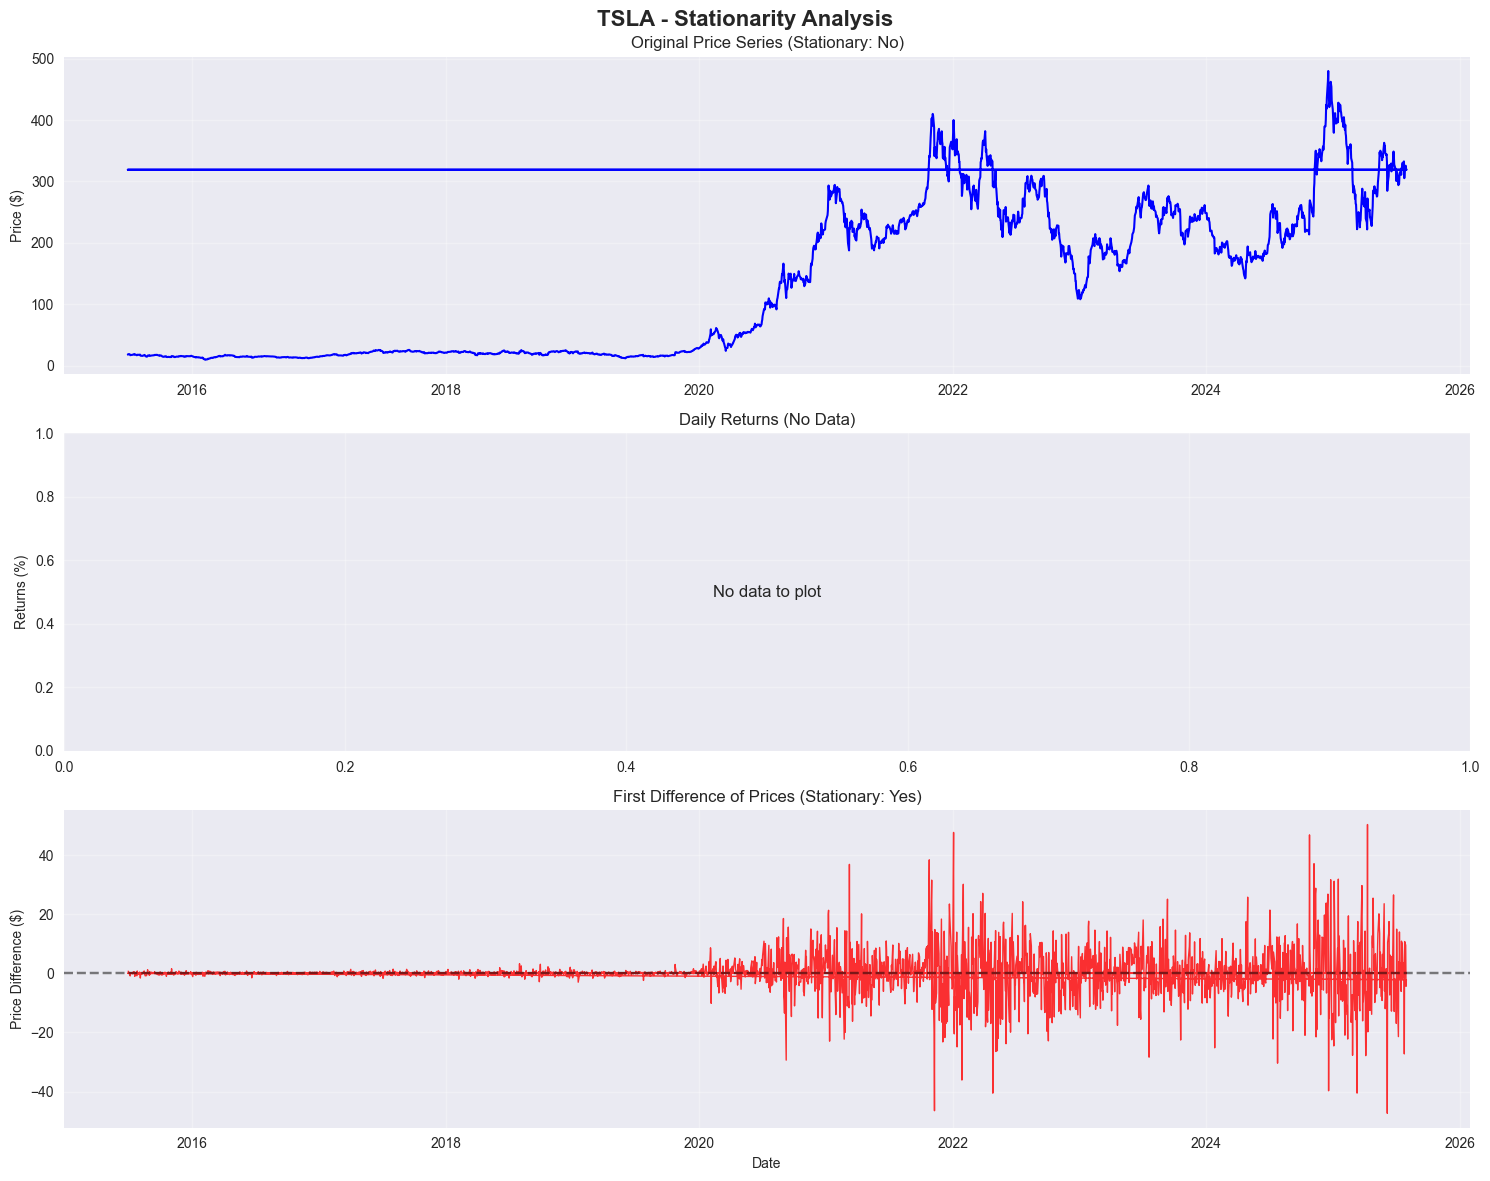

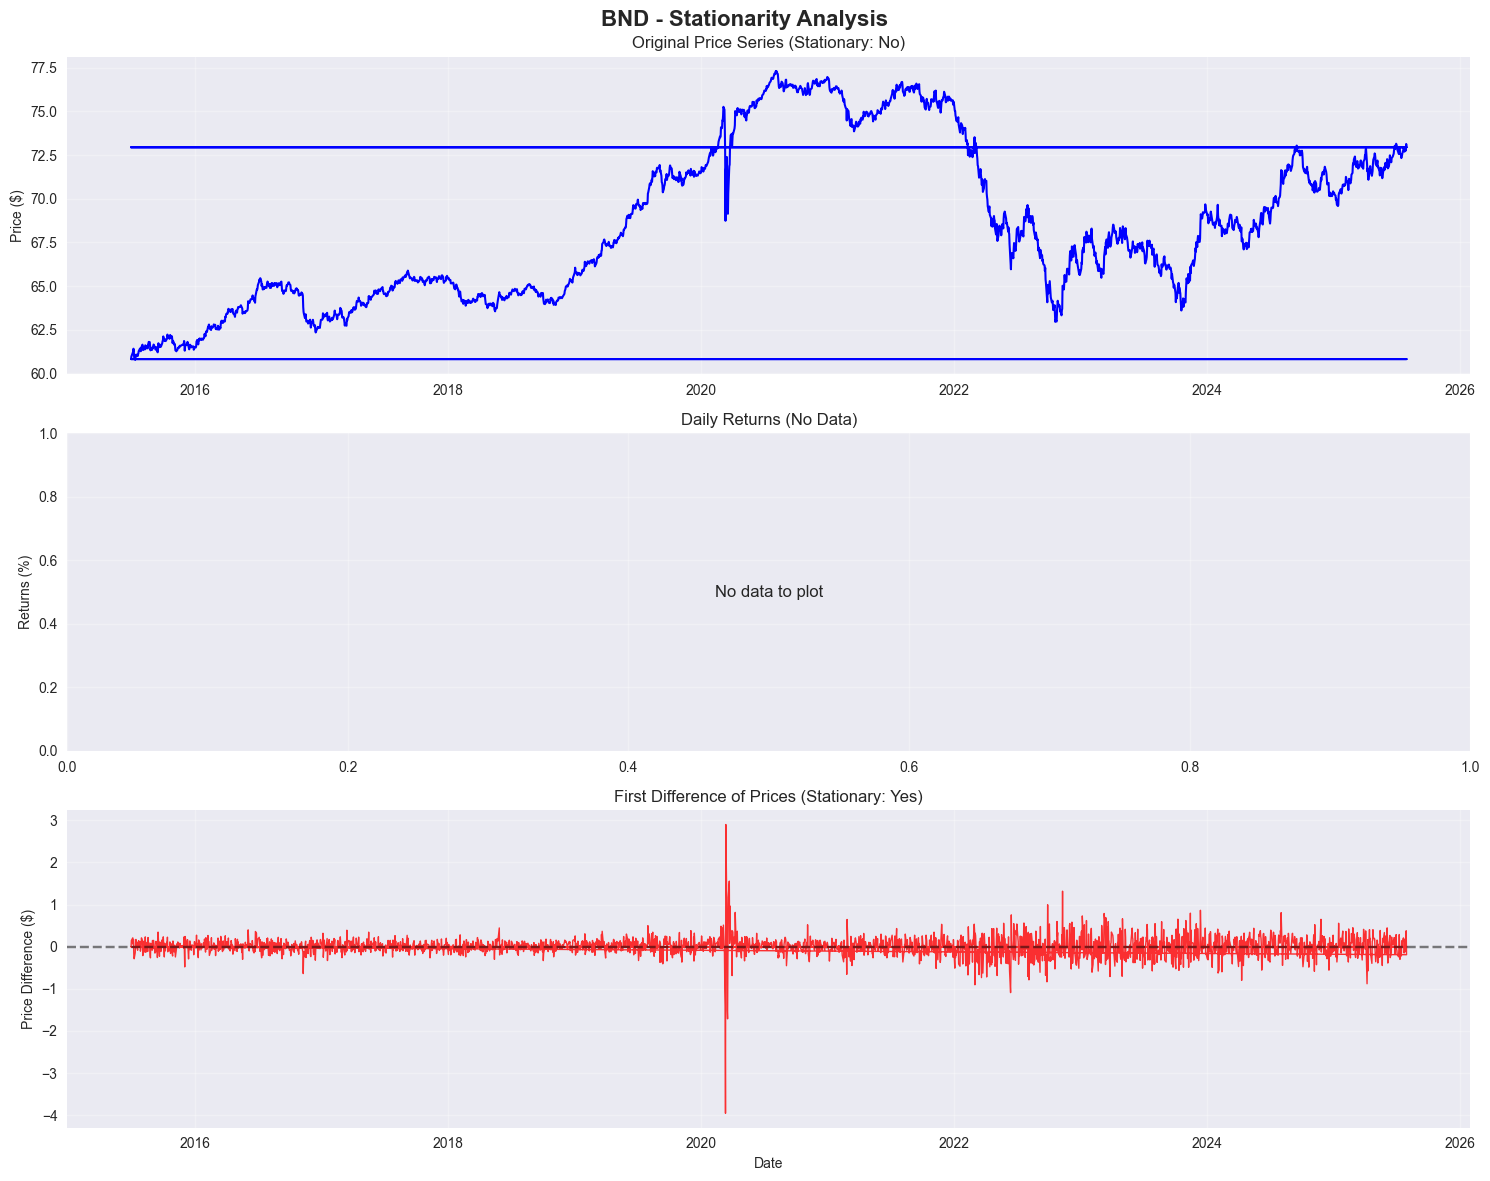

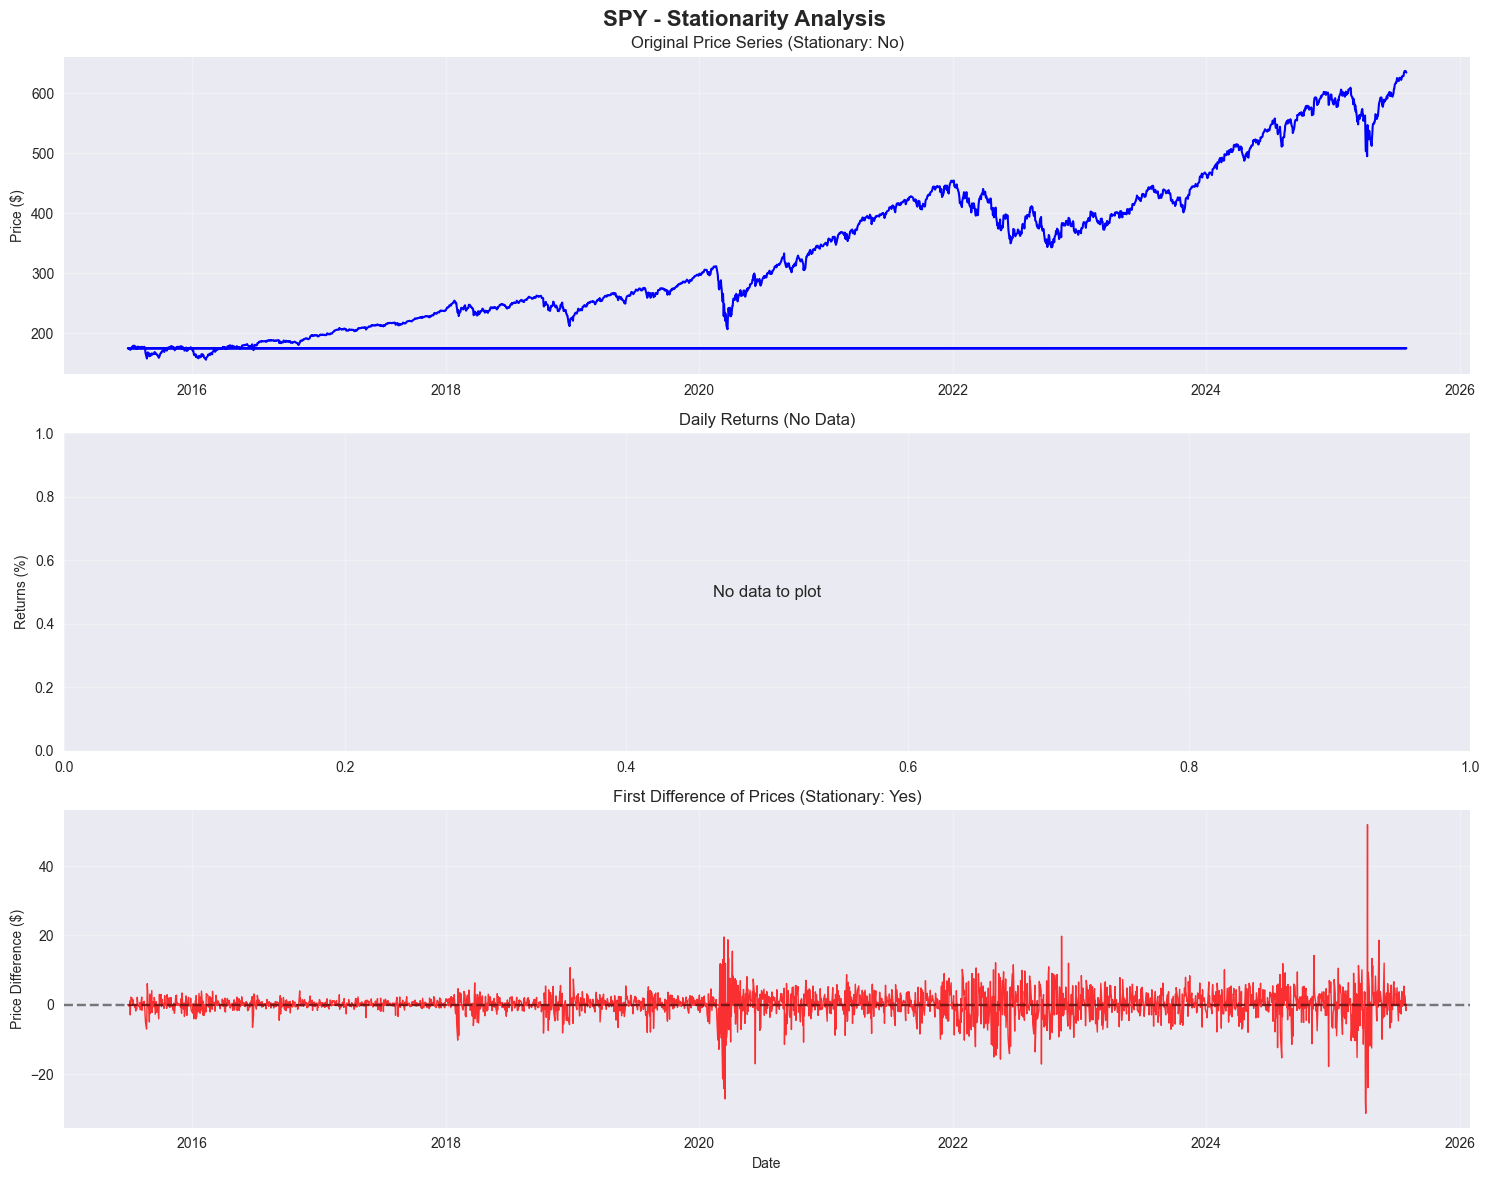


IMPLICATIONS FOR ARIMA MODELING

TSLA:
  ✗ Prices are non-stationary - need differencing
  ✓ First difference is stationary - can use ARIMA with d=1
  ✓ Returns are stationary - suitable for volatility modeling
  Recommended ARIMA order: ARIMA(p,1,q)
  (where p and q need to be determined through ACF/PACF analysis)

BND:
  ✗ Prices are non-stationary - need differencing
  ✓ First difference is stationary - can use ARIMA with d=1
  ✓ Returns are stationary - suitable for volatility modeling
  Recommended ARIMA order: ARIMA(p,1,q)
  (where p and q need to be determined through ACF/PACF analysis)

SPY:
  ✗ Prices are non-stationary - need differencing
  ✓ First difference is stationary - can use ARIMA with d=1
  ✓ Returns are stationary - suitable for volatility modeling
  Recommended ARIMA order: ARIMA(p,1,q)
  (where p and q need to be determined through ACF/PACF analysis)


In [11]:
# Stationarity Testing with ADF Test
print("=== STATIONARITY TESTING (AUGMENTED DICKEY-FULLER TEST) ===\n")

def interpret_adf_results(adf_result, series_name):
    """
    Interpret ADF test results and provide detailed explanation
    """
    adf_statistic = adf_result[0]
    p_value = adf_result[1]
    critical_values = adf_result[4]
    
    print(f"{series_name}:")
    print(f"  ADF Statistic: {adf_statistic:.6f}")
    print(f"  p-value: {p_value:.6f}")
    print("  Critical Values:")
    for level, cv in critical_values.items():
        print(f"    {level}: {cv:.6f}")
    
    # Interpretation
    if p_value <= 0.05:
        print("  ✓ RESULT: Series is STATIONARY (reject null hypothesis)")
        print("    The series does not have a unit root and is suitable for ARIMA modeling")
    else:
        print("  ✗ RESULT: Series is NON-STATIONARY (fail to reject null hypothesis)")
        print("    The series has a unit root and requires differencing for ARIMA modeling")
    
    # Additional interpretation based on critical values
    if adf_statistic < critical_values['1%']:
        confidence = "99%"
    elif adf_statistic < critical_values['5%']:
        confidence = "95%"
    elif adf_statistic < critical_values['10%']:
        confidence = "90%"
    else:
        confidence = "less than 90%"
    
    print(f"  Confidence level for stationarity: {confidence}")
    print()

adf_results = {}

for ticker in TICKERS:
    ticker_data = volatility_data[ticker].copy()
    print(f"{'='*50}")
    print(f"ADF Test Results for {ticker}")
    print(f"{'='*50}")
    
    # Test on closing prices
    close_series = ticker_data['Close'].dropna()
    if close_series.empty or close_series.max() == close_series.min():
        print(f"  Skipping ADF test for {ticker} - Closing Prices (empty or constant series)")
        adf_prices = None
    else:
        adf_prices = adfuller(close_series, autolag='AIC')
        interpret_adf_results(adf_prices, f"{ticker} - Closing Prices")
    
    # Test on daily returns
    returns_series = ticker_data['Daily_Return'].dropna()
    if returns_series.empty or returns_series.max() == returns_series.min():
        print(f"  Skipping ADF test for {ticker} - Daily Returns (empty or constant series)")
        adf_returns = None
    else:
        adf_returns = adfuller(returns_series, autolag='AIC')
        interpret_adf_results(adf_returns, f"{ticker} - Daily Returns")
    
    # Test on first difference of prices (differenced series)
    price_diff = close_series.diff().dropna()
    if price_diff.empty or price_diff.max() == price_diff.min():
        print(f"  Skipping ADF test for {ticker} - First Difference of Prices (empty or constant series)")
        adf_diff = None
    else:
        adf_diff = adfuller(price_diff, autolag='AIC')
        interpret_adf_results(adf_diff, f"{ticker} - First Difference of Prices")
    
    adf_results[ticker] = {
        'prices': adf_prices,
        'returns': adf_returns,
        'price_diff': adf_diff,
        'price_series': close_series,
        'returns_series': returns_series,
        'diff_series': price_diff
    }

# Summary table of ADF test results
print("="*80)
print("SUMMARY OF ADF TEST RESULTS")
print("="*80)

summary_data = []
for ticker in TICKERS:
    results = adf_results[ticker]
    # Prices
    if results['prices'] is not None:
        summary_data.append({
            'Asset': ticker,
            'Series': 'Prices',
            'ADF Statistic': f"{results['prices'][0]:.4f}",
            'p-value': f"{results['prices'][1]:.4f}",
            'Stationary': 'Yes' if results['prices'][1] <= 0.05 else 'No'
        })
    else:
        summary_data.append({
            'Asset': ticker,
            'Series': 'Prices',
            'ADF Statistic': 'N/A',
            'p-value': 'N/A',
            'Stationary': 'N/A'
        })
    # Returns
    if results['returns'] is not None:
        summary_data.append({
            'Asset': ticker,
            'Series': 'Returns',
            'ADF Statistic': f"{results['returns'][0]:.4f}",
            'p-value': f"{results['returns'][1]:.4f}",
            'Stationary': 'Yes' if results['returns'][1] <= 0.05 else 'No'
        })
    else:
        summary_data.append({
            'Asset': ticker,
            'Series': 'Returns',
            'ADF Statistic': 'N/A',
            'p-value': 'N/A',
            'Stationary': 'N/A'
        })
    # First Difference
    if results['price_diff'] is not None:
        summary_data.append({
            'Asset': ticker,
            'Series': '1st Diff',
            'ADF Statistic': f"{results['price_diff'][0]:.4f}",
            'p-value': f"{results['price_diff'][1]:.4f}",
            'Stationary': 'Yes' if results['price_diff'][1] <= 0.05 else 'No'
        })
    else:
        summary_data.append({
            'Asset': ticker,
            'Series': '1st Diff',
            'ADF Statistic': 'N/A',
            'p-value': 'N/A',
            'Stationary': 'N/A'
        })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

# Visualize the series and their stationarity
for ticker in TICKERS:
    results = adf_results[ticker]
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    fig.suptitle(f'{ticker} - Stationarity Analysis', fontsize=16, fontweight='bold')
    dates = volatility_data[ticker]['Date']
    # Original price series
    price_series = results['price_series']
    if price_series is not None and not price_series.empty and len(dates) == len(price_series):
        axes[0].plot(dates, price_series, linewidth=1.5, color='blue')
        axes[0].set_title(f'Original Price Series (Stationary: {"Yes" if results["prices"] is not None and results["prices"][1] <= 0.05 else "No"})', fontsize=12)
        axes[0].set_ylabel('Price ($)', fontsize=10)
        axes[0].grid(True, alpha=0.3)
    else:
        axes[0].text(0.5, 0.5, 'No data to plot', ha='center', va='center', fontsize=12)
        axes[0].set_title('Original Price Series (No Data)', fontsize=12)
        axes[0].set_ylabel('Price ($)', fontsize=10)
        axes[0].grid(True, alpha=0.3)
    # Daily returns
    returns_series = results['returns_series']
    if returns_series is not None and not returns_series.empty and len(dates) == len(returns_series):
        axes[1].plot(dates, returns_series * 100, linewidth=1, color='green', alpha=0.8)
        axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
        axes[1].set_title(f'Daily Returns (Stationary: {"Yes" if results["returns"] is not None and results["returns"][1] <= 0.05 else "No"})', fontsize=12)
        axes[1].set_ylabel('Returns (%)', fontsize=10)
        axes[1].grid(True, alpha=0.3)
    else:
        axes[1].text(0.5, 0.5, 'No data to plot', ha='center', va='center', fontsize=12)
        axes[1].set_title('Daily Returns (No Data)', fontsize=12)
        axes[1].set_ylabel('Returns (%)', fontsize=10)
        axes[1].grid(True, alpha=0.3)
    # First difference of prices
    diff_series = results['diff_series']
    diff_dates = dates[1:] if len(dates) > 1 else dates
    if diff_series is not None and not diff_series.empty and len(diff_dates) == len(diff_series):
        axes[2].plot(diff_dates, diff_series, linewidth=1, color='red', alpha=0.8)
        axes[2].axhline(y=0, color='black', linestyle='--', alpha=0.5)
        axes[2].set_title(f'First Difference of Prices (Stationary: {"Yes" if results["price_diff"] is not None and results["price_diff"][1] <= 0.05 else "No"})', fontsize=12)
        axes[2].set_ylabel('Price Difference ($)', fontsize=10)
        axes[2].set_xlabel('Date', fontsize=10)
        axes[2].grid(True, alpha=0.3)
    else:
        axes[2].text(0.5, 0.5, 'No data to plot', ha='center', va='center', fontsize=12)
        axes[2].set_title('First Difference of Prices (No Data)', fontsize=12)
        axes[2].set_ylabel('Price Difference ($)', fontsize=10)
        axes[2].set_xlabel('Date', fontsize=10)
        axes[2].grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Implications for ARIMA modeling
print("\n" + "="*80)
print("IMPLICATIONS FOR ARIMA MODELING")
print("="*80)
for ticker in TICKERS:
    results = adf_results[ticker]
    prices_stationary = results['prices'] is not None and results['prices'][1] <= 0.05
    returns_stationary = results['returns'] is not None and results['returns'][1] <= 0.05
    print(f"\n{ticker}:")
    if prices_stationary:
        print("  ✓ Prices are stationary - can use ARMA model")
        print("  ✓ For ARIMA: d=0 (no differencing needed)")
    else:
        print("  ✗ Prices are non-stationary - need differencing")
        if results['price_diff'] is not None and results['price_diff'][1] <= 0.05:
            print("  ✓ First difference is stationary - can use ARIMA with d=1")
        else:
            print("  ⚠ May need higher order differencing (d>1)")
    if returns_stationary:
        print("  ✓ Returns are stationary - suitable for volatility modeling")
    else:
        print("  ⚠ Returns may need additional preprocessing")
    print(f"  Recommended ARIMA order: ARIMA(p,{'0' if prices_stationary else '1'},q)")
    print("  (where p and q need to be determined through ACF/PACF analysis)")

=== RISK METRICS CALCULATION ===

Detailed Risk Metrics Analysis:

TSLA (Tesla Inc. - High-growth, high-risk automobile manufacturing stock):
--------------------------------------------------
Return Metrics:
  Daily Mean Return:      0.0609%
  Annualized Return:      15.35%
  Daily Volatility:       2.1538%
  Annualized Volatility:  34.19%

Risk-Adjusted Performance:
  Sharpe Ratio:          0.3905
  Sortino Ratio:         0.3336
  Maximum Drawdown:      -73.63%

Value at Risk (VaR):
  VaR (95%):             -2.94%
  VaR (99%):             -6.81%

Conditional VaR (Expected Shortfall):
  CVaR (95%):            -5.36%
  CVaR (99%):            -9.57%

Distribution Characteristics:
  Skewness:              0.6790
  Kurtosis:              18.9947

BND (Vanguard Total Bond Market ETF - Provides stability and income):
--------------------------------------------------
Return Metrics:
  Daily Mean Return:      0.0026%
  Annualized Return:      0.65%
  Daily Volatility:       0.1997%
  Annuali

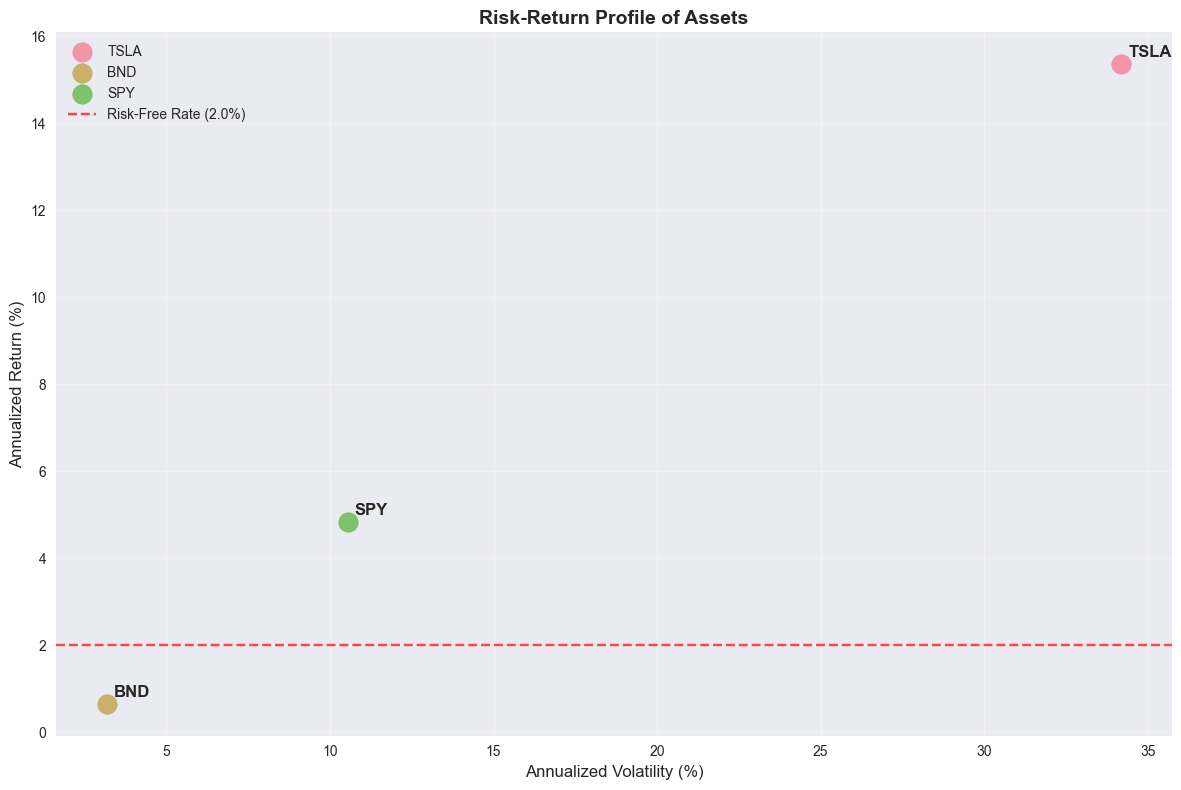

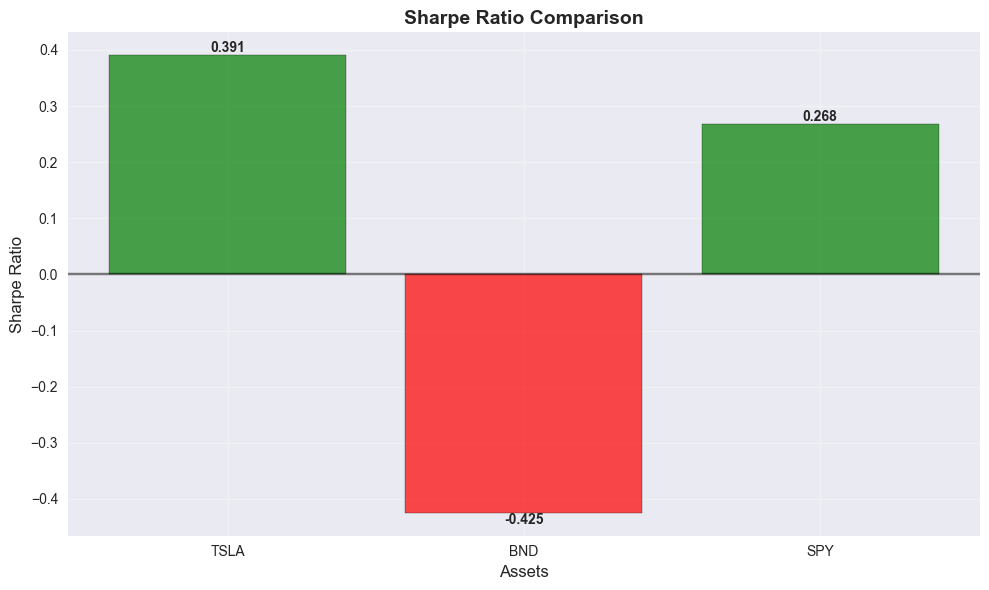

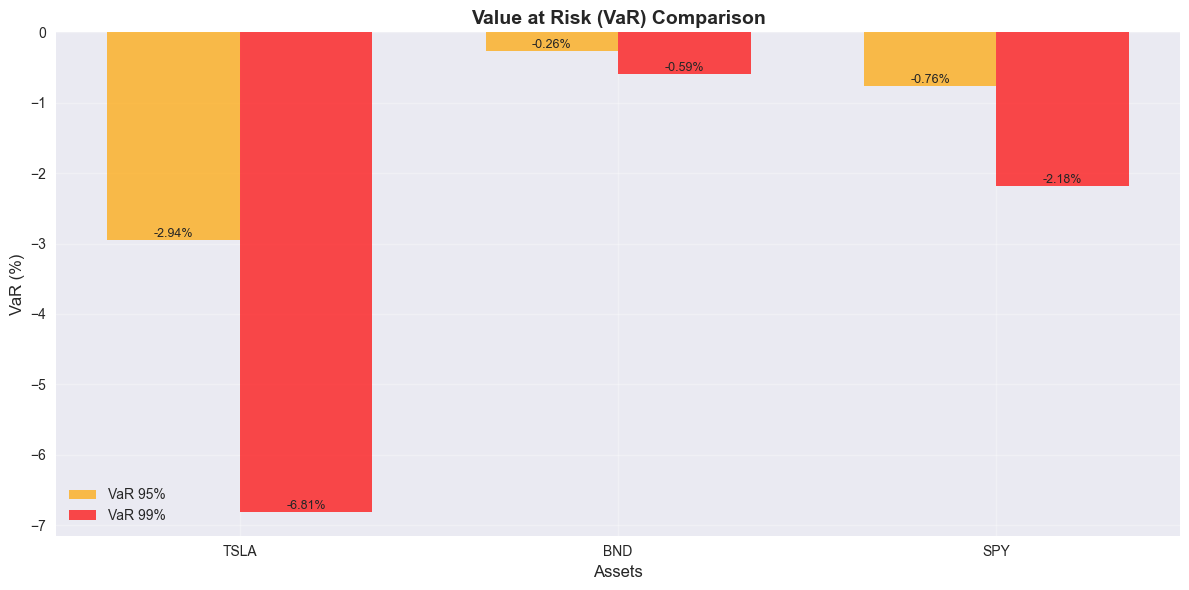


RISK METRICS SUMMARY TABLE
Asset Ann. Return (%) Ann. Volatility (%) Sharpe Ratio Max Drawdown (%) VaR 95% (%) VaR 99% (%) Skewness Kurtosis
 TSLA           15.35               34.19       0.3905           -73.63       -2.94       -6.81   0.6790  18.9947
  BND            0.65                3.17      -0.4248           -18.58       -0.26       -0.59  -1.5572 114.6456
  SPY            4.83               10.54       0.2683           -33.72       -0.76       -2.18  -0.3613  47.3953

RISK ASSESSMENT INSIGHTS

TSLA:
  Risk Level: HIGH RISK (Volatility: 34.2%)
  Risk-Adjusted Performance: Fair (Sharpe: 0.391)
  Return Distribution: Significantly skewed, Heavy tails (higher crash risk)
  Potential Daily Loss (95% confidence): Up to 2.94%
  Extreme Daily Loss (99% confidence): Up to 6.81%

BND:
  Risk Level: LOW RISK (Volatility: 3.2%)
  Risk-Adjusted Performance: Poor (Sharpe: -0.425)
  Return Distribution: Significantly skewed, Heavy tails (higher crash risk)
  Potential Daily Loss (95% conf

In [12]:
# Risk Metrics Calculation (VaR and Sharpe Ratio)
print("=== RISK METRICS CALCULATION ===\n")

# Risk-free rate (approximation - can be updated with current treasury rates)
RISK_FREE_RATE = 0.02  # 2% annual risk-free rate

def calculate_risk_metrics(returns_series, confidence_levels=[0.95, 0.99]):
    """
    Calculate comprehensive risk metrics for a returns series
    """
    # Remove NaN values
    clean_returns = returns_series.dropna()
    if clean_returns.empty:
        return {
            'mean_daily_return': np.nan,
            'daily_volatility': np.nan,
            'annualized_return': np.nan,
            'annualized_volatility': np.nan,
            'sharpe_ratio': np.nan,
            'sortino_ratio': np.nan,
            'max_drawdown': np.nan,
            'skewness': np.nan,
            'kurtosis': np.nan,
            'var_95': np.nan,
            'var_99': np.nan,
            'cvar_95': np.nan,
            'cvar_99': np.nan,
            'total_observations': 0
        }
    
    # Basic statistics
    mean_return = clean_returns.mean()
    std_return = clean_returns.std()
    
    # Annualized metrics
    annualized_return = mean_return * 252
    annualized_volatility = std_return * np.sqrt(252)
    
    # Value at Risk (VaR)
    var_metrics = {}
    for conf in confidence_levels:
        var_metrics[f'VaR_{int(conf*100)}'] = np.percentile(clean_returns, (1-conf)*100)
    
    # Conditional Value at Risk (Expected Shortfall)
    cvar_metrics = {}
    for conf in confidence_levels:
        threshold = var_metrics[f'VaR_{int(conf*100)}']
        tail_losses = clean_returns[clean_returns <= threshold]
        cvar_metrics[f'CVaR_{int(conf*100)}'] = tail_losses.mean() if len(tail_losses) > 0 else np.nan
    
    # Sharpe Ratio
    excess_return = annualized_return - RISK_FREE_RATE
    sharpe_ratio = excess_return / annualized_volatility if annualized_volatility != 0 else np.nan
    
    # Maximum Drawdown
    cumulative_returns = (1 + clean_returns).cumprod()
    running_max = cumulative_returns.expanding().max()
    drawdowns = (cumulative_returns - running_max) / running_max
    max_drawdown = drawdowns.min()
    
    # Downside deviation (for Sortino ratio)
    downside_returns = clean_returns[clean_returns < 0]
    downside_deviation = downside_returns.std() * np.sqrt(252) if len(downside_returns) > 0 else 0
    sortino_ratio = excess_return / downside_deviation if downside_deviation != 0 else np.nan
    
    # Skewness and Kurtosis
    skewness = clean_returns.skew()
    kurtosis = clean_returns.kurtosis()
    
    return {
        'mean_daily_return': mean_return,
        'daily_volatility': std_return,
        'annualized_return': annualized_return,
        'annualized_volatility': annualized_volatility,
        'sharpe_ratio': sharpe_ratio,
        'sortino_ratio': sortino_ratio,
        'max_drawdown': max_drawdown,
        'skewness': skewness,
        'kurtosis': kurtosis,
        'var_95': var_metrics['VaR_95'],
        'var_99': var_metrics['VaR_99'],
        'cvar_95': cvar_metrics['CVaR_95'],
        'cvar_99': cvar_metrics['CVaR_99'],
        'total_observations': len(clean_returns)
    }

# Calculate risk metrics for each asset
risk_metrics = {}

print("Detailed Risk Metrics Analysis:")
print("="*60)

for ticker in TICKERS:
    ticker_data = volatility_data[ticker]
    metrics = calculate_risk_metrics(ticker_data['Daily_Return'])
    risk_metrics[ticker] = metrics
    
    print(f"\n{ticker} ({asset_info[ticker]}):")
    print("-" * 50)
    print(f"Return Metrics:")
    print(f"  Daily Mean Return:      {metrics['mean_daily_return']*100:.4f}%")
    print(f"  Annualized Return:      {metrics['annualized_return']*100:.2f}%")
    print(f"  Daily Volatility:       {metrics['daily_volatility']*100:.4f}%")
    print(f"  Annualized Volatility:  {metrics['annualized_volatility']*100:.2f}%")
    
    print(f"\nRisk-Adjusted Performance:")
    print(f"  Sharpe Ratio:          {metrics['sharpe_ratio']:.4f}")
    print(f"  Sortino Ratio:         {metrics['sortino_ratio']:.4f}")
    print(f"  Maximum Drawdown:      {metrics['max_drawdown']*100:.2f}%")
    
    print(f"\nValue at Risk (VaR):")
    print(f"  VaR (95%):             {metrics['var_95']*100:.2f}%")
    print(f"  VaR (99%):             {metrics['var_99']*100:.2f}%")
    
    print(f"\nConditional VaR (Expected Shortfall):")
    print(f"  CVaR (95%):            {metrics['cvar_95']*100:.2f}%")
    print(f"  CVaR (99%):            {metrics['cvar_99']*100:.2f}%")
    
    print(f"\nDistribution Characteristics:")
    print(f"  Skewness:              {metrics['skewness']:.4f}")
    print(f"  Kurtosis:              {metrics['kurtosis']:.4f}")

# Create comparative visualizations
# Risk-Return Scatter Plot
plt.figure(figsize=(12, 8))
for ticker in TICKERS:
    metrics = risk_metrics[ticker]
    plt.scatter(metrics['annualized_volatility']*100, metrics['annualized_return']*100, 
               s=200, alpha=0.7, label=ticker)
    
    # Add asset labels
    plt.annotate(ticker, 
                (metrics['annualized_volatility']*100, metrics['annualized_return']*100),
                xytext=(5, 5), textcoords='offset points', fontsize=12, fontweight='bold')

plt.xlabel('Annualized Volatility (%)', fontsize=12)
plt.ylabel('Annualized Return (%)', fontsize=12)
plt.title('Risk-Return Profile of Assets', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)

# Add risk-free rate line
plt.axhline(y=RISK_FREE_RATE*100, color='red', linestyle='--', alpha=0.7, 
           label=f'Risk-Free Rate ({RISK_FREE_RATE*100:.1f}%)')
plt.legend()
plt.tight_layout()
plt.show()

# Sharpe Ratio Comparison
sharpe_ratios = [risk_metrics[ticker]['sharpe_ratio'] for ticker in TICKERS]
colors = ['red' if sr < 0 else 'green' for sr in sharpe_ratios]

plt.figure(figsize=(10, 6))
bars = plt.bar(TICKERS, sharpe_ratios, color=colors, alpha=0.7, edgecolor='black')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
plt.title('Sharpe Ratio Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Assets', fontsize=12)
plt.ylabel('Sharpe Ratio', fontsize=12)
plt.grid(True, alpha=0.3)

# Add value labels on bars
for bar, ratio in zip(bars, sharpe_ratios):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{ratio:.3f}',
             ha='center', va='bottom' if height >= 0 else 'top', fontweight='bold')

plt.tight_layout()
plt.show()

# VaR Comparison
var_95 = [risk_metrics[ticker]['var_95']*100 for ticker in TICKERS]
var_99 = [risk_metrics[ticker]['var_99']*100 for ticker in TICKERS]

x = np.arange(len(TICKERS))
width = 0.35

plt.figure(figsize=(12, 6))
plt.bar(x - width/2, var_95, width, label='VaR 95%', alpha=0.7, color='orange')
plt.bar(x + width/2, var_99, width, label='VaR 99%', alpha=0.7, color='red')

plt.title('Value at Risk (VaR) Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Assets', fontsize=12)
plt.ylabel('VaR (%)', fontsize=12)
plt.xticks(x, TICKERS)
plt.legend()
plt.grid(True, alpha=0.3)

# Add value labels
for i, (v95, v99) in enumerate(zip(var_95, var_99)):
    plt.text(i - width/2, v95, f'{v95:.2f}%', ha='center', va='bottom', fontsize=9)
    plt.text(i + width/2, v99, f'{v99:.2f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Summary Risk Metrics Table
print("\n" + "="*80)
print("RISK METRICS SUMMARY TABLE")
print("="*80)

summary_metrics = []
for ticker in TICKERS:
    metrics = risk_metrics[ticker]
    summary_metrics.append({
        'Asset': ticker,
        'Ann. Return (%)': f"{metrics['annualized_return']*100:.2f}",
        'Ann. Volatility (%)': f"{metrics['annualized_volatility']*100:.2f}",
        'Sharpe Ratio': f"{metrics['sharpe_ratio']:.4f}",
        'Max Drawdown (%)': f"{metrics['max_drawdown']*100:.2f}",
        'VaR 95% (%)': f"{metrics['var_95']*100:.2f}",
        'VaR 99% (%)': f"{metrics['var_99']*100:.2f}",
        'Skewness': f"{metrics['skewness']:.4f}",
        'Kurtosis': f"{metrics['kurtosis']:.4f}"
    })

summary_df = pd.DataFrame(summary_metrics)
print(summary_df.to_string(index=False))

print("\n" + "="*80)
print("RISK ASSESSMENT INSIGHTS")
print("="*80)

for ticker in TICKERS:
    metrics = risk_metrics[ticker]
    print(f"\n{ticker}:")
    
    # Risk level assessment
    vol = metrics['annualized_volatility']
    if vol > 0.3:
        risk_level = "HIGH RISK"
    elif vol > 0.15:
        risk_level = "MODERATE RISK"
    else:
        risk_level = "LOW RISK"
    
    print(f"  Risk Level: {risk_level} (Volatility: {vol*100:.1f}%)")
    
    # Sharpe ratio assessment
    sharpe = metrics['sharpe_ratio']
    if sharpe > 1:
        sharpe_assessment = "Excellent"
    elif sharpe > 0.5:
        sharpe_assessment = "Good"
    elif sharpe > 0:
        sharpe_assessment = "Fair"
    else:
        sharpe_assessment = "Poor"
    
    print(f"  Risk-Adjusted Performance: {sharpe_assessment} (Sharpe: {sharpe:.3f})")
    
    # Distribution characteristics
    if abs(metrics['skewness']) > 0.5:
        skew_desc = "Significantly skewed"
    else:
        skew_desc = "Approximately symmetric"
    
    if metrics['kurtosis'] > 3:
        kurt_desc = "Heavy tails (higher crash risk)"
    else:
        kurt_desc = "Normal tail characteristics"
    
    print(f"  Return Distribution: {skew_desc}, {kurt_desc}")
    
    # VaR interpretation
    print(f"  Potential Daily Loss (95% confidence): Up to {abs(metrics['var_95']*100):.2f}%")
    print(f"  Extreme Daily Loss (99% confidence): Up to {abs(metrics['var_99']*100):.2f}%")

In [14]:
# Save Cleaned Data
print("=== SAVING CLEANED DATA ===\n")

# Prepare the final dataset with all calculated metrics
final_data = pd.DataFrame()

for ticker in TICKERS:
    # Convert the volatility_data dictionary to a DataFrame
    ticker_data = pd.DataFrame(volatility_data[ticker])
    
    # Add additional calculated columns that might be useful for future analysis
    ticker_data['Ticker'] = ticker
    ticker_data['Year'] = ticker_data['Date'].dt.year
    ticker_data['Month'] = ticker_data['Date'].dt.month
    ticker_data['Weekday'] = ticker_data['Date'].dt.dayofweek
    
    # Add log returns (useful for statistical modeling)
    ticker_data['Log_Return'] = np.log(ticker_data['Close'] / ticker_data['Close'].shift(1))
    
    # Add price change and percentage change
    ticker_data['Price_Change'] = ticker_data['Close'] - ticker_data['Close'].shift(1)
    ticker_data['Price_Change_Pct'] = ticker_data['Price_Change'] / ticker_data['Close'].shift(1)
    
    final_data = pd.concat([final_data, ticker_data], ignore_index=True)

# Create directory if it doesn't exist
import os
os.makedirs('../data', exist_ok=True)

# Save to CSV
output_path = '../data/cleaned_financial_data.csv'
final_data.to_csv(output_path, index=False)

print(f"✓ Cleaned data saved to: {output_path}")
print(f"✓ Total records: {len(final_data):,}")
print(f"✓ Date range: {final_data['Date'].min().strftime('%Y-%m-%d')} to {final_data['Date'].max().strftime('%Y-%m-%d')}")

# Display final dataset structure
print(f"\nFinal Dataset Structure:")
print(f"Shape: {final_data.shape}")
print(f"Columns: {list(final_data.columns)}")

print("\nColumn Descriptions:")
column_descriptions = {
    'Date': 'Trading date',
    'Open': 'Opening price',
    'High': 'Highest price of the day',
    'Low': 'Lowest price of the day', 
    'Close': 'Closing price',
    'Adj Close': 'Adjusted closing price (accounts for dividends/splits)',
    'Volume': 'Trading volume',
    'Ticker': 'Asset ticker symbol',
    'Daily_Return': 'Daily percentage return',
    'Rolling_Mean_21': '21-day rolling mean of closing price',
    'Rolling_Std_21': '21-day rolling standard deviation',
    'Rolling_Volatility_21': '21-day annualized volatility',
    'Z_Score': 'Z-score of daily returns (for outlier detection)',
    'Year': 'Year extracted from date',
    'Month': 'Month extracted from date', 
    'Weekday': 'Day of week (0=Monday, 6=Sunday)',
    'Log_Return': 'Natural logarithm of return',
    'Price_Change': 'Absolute price change from previous day',
    'Price_Change_Pct': 'Percentage price change from previous day'
}

for col, desc in column_descriptions.items():
    if col in final_data.columns:
        print(f"  {col}: {desc}")

# Display sample of final data
print("\nSample of Final Dataset:")
print(final_data.head(10).to_string())

# Save summary statistics
summary_stats_path = '../data/risk_metrics_summary.csv'
risk_summary_df = pd.DataFrame(risk_metrics).T
risk_summary_df.to_csv(summary_stats_path)
print(f"\n✓ Risk metrics summary saved to: {summary_stats_path}")

print("\n" + "="*60)
print("DATA PREPROCESSING AND ANALYSIS COMPLETED SUCCESSFULLY!")
print("="*60)
print("Ready for:")
print("- Time series modeling (ARIMA, GARCH)")
print("- Portfolio optimization")
print("- Risk management analysis")
print("- Machine learning applications")
print("- Further statistical analysis")

=== SAVING CLEANED DATA ===

✓ Cleaned data saved to: ../data/cleaned_financial_data.csv
✓ Total records: 22,815
✓ Date range: 2015-07-01 to 2025-07-30

Final Dataset Structure:
Shape: (22815, 19)
Columns: ['Date', 'Close', 'Daily_Return', 'Rolling_Mean_21', 'Rolling_Std_21', 'Rolling_Volatility_21', 'Rolling_Mean_63', 'Rolling_Std_63', 'Rolling_Volatility_63', 'Rolling_Mean_252', 'Rolling_Std_252', 'Rolling_Volatility_252', 'Ticker', 'Year', 'Month', 'Weekday', 'Log_Return', 'Price_Change', 'Price_Change_Pct']

Column Descriptions:
  Date: Trading date
  Close: Closing price
  Ticker: Asset ticker symbol
  Daily_Return: Daily percentage return
  Rolling_Mean_21: 21-day rolling mean of closing price
  Rolling_Std_21: 21-day rolling standard deviation
  Rolling_Volatility_21: 21-day annualized volatility
  Year: Year extracted from date
  Month: Month extracted from date
  Weekday: Day of week (0=Monday, 6=Sunday)
  Log_Return: Natural logarithm of return
  Price_Change: Absolute price 